In [1]:
import sys
import gc
import os
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import scvi
import plotnine as p9 
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

sys.path.append('TS_DEG_method/')
import utils,figure_all

In [2]:
%load_ext autoreload
%autoreload 2
#%reload_ext autoreload

In [3]:
edgeR_LRT_all = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/TS_project/edgeR_LRT_all_DEGs.csv',index_col=0)
edgeR_LRT_all.index = edgeR_LRT_all['gene_symbol'].values

edgeR_LRT_all_tissue = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/TS_project/edgeR_LRT_all_DEGs_tissue.csv',index_col=0)
edgeR_LRT_all_tissue.index = edgeR_LRT_all_tissue['gene_symbol'].values


In [4]:
gtf = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/TS_project/gencode.v41.annotation.gtf', comment='#', sep='\t', header=None)
gtf_columns = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
gtf.columns = gtf_columns

# Extract gene name and gene type from the attributes column
gtf['gene_name'] = gtf['attribute'].str.extract('gene_name "([^"]+)"')
gtf['gene_type'] = gtf['attribute'].str.extract('gene_type "([^"]+)"')
gtf['chr'] = gtf['seqname']

gene_info_mapping = gtf[['gene_name', 'chr', 'gene_type']].drop_duplicates().set_index('gene_name')



In [5]:
chromosome_classification = {
    'chrY': 'chrY',
    'chrX': 'chrX',
    'chr16': 'autosomal',
    'chr20': 'autosomal',
    'chr1': 'autosomal',
    'chr8': 'autosomal',
    'chr6': 'autosomal',
    'chr9': 'autosomal',
    'chr10': 'autosomal',
    'chr18': 'autosomal',
    'chr14': 'autosomal',
    'chr22': 'autosomal',
    'chr2': 'autosomal',
    'chr21': 'autosomal',
    'chr12': 'autosomal',
    'chr5': 'autosomal',
    'chr19': 'autosomal',
    'chr3': 'autosomal',
    'chrM': 'chrM',
    'chr17': 'autosomal',
    'chr15': 'autosomal',
    'chr4': 'autosomal',
    'chr7': 'autosomal',
    'chr11': 'autosomal',
    'chr13': 'autosomal',
    np.nan: 'nan'
}

In [6]:
gene_type_classification = {
    'chrY_protein_coding': 'chrY',
    'chrY_transcribed_unitary_pseudogene': 'chrY',
    'chrX_lncRNA': 'chrX',
    'chrY_transcribed_unprocessed_pseudogene': 'chrY',
    'chrY_lncRNA': 'chrY',
    'chrX_protein_coding': 'chrX',
    'autosomal_protein_coding': 'Autosomal-coding',
    'autosomal_processed_pseudogene': 'Autosomal-noncoding',
    'autosomal_lncRNA': 'Autosomal-noncoding',
    'chrY_unprocessed_pseudogene': 'chrY',
    'chrM_protein_coding': 'MT-mt',
    'chrY_processed_pseudogene': 'chrY',
    'autosomal_transcribed_unprocessed_pseudogene': 'Autosomal-noncoding',
    'chrX_transcribed_processed_pseudogene': 'chrX',
    'autosomal_TR_C_gene': 'Autosomal-coding',
    'chrX_processed_pseudogene': 'chrX',
    'chrM_Mt_rRNA': 'MT-mt',
    'autosomal_transcribed_unitary_pseudogene': 'Autosomal-noncoding',
    'chrX_unprocessed_pseudogene': 'chrX',
    'autosomal_transcribed_processed_pseudogene': 'Autosomal-noncoding',
    'chrX_transcribed_unprocessed_pseudogene': 'chrX',
    'autosomal_misc_RNA': 'Autosomal-noncoding',
    'chrY_transcribed_processed_pseudogene': 'chrY',
    'autosomal_unprocessed_pseudogene': 'Autosomal-noncoding',
    'chrM_Mt_tRNA': 'MT-mt',
    'autosomal_TEC': 'Autosomal-noncoding',
    'chrX_transcribed_unitary_pseudogene': 'chrX',
    'chrX_misc_RNA': 'chrX',
    'chrX_snRNA': 'chrX',
    'chrY_misc_RNA': 'chrY',
    'chrX_snoRNA': 'chrX',
    'chrX_TEC': 'chrX',
    'chrX_pseudogene': 'chrX',
    'chrX_miRNA': 'chrX',
    'chrX_unitary_pseudogene': 'chrX',
    np.nan: 'nan',
    'autosomal_snoRNA': 'Autosomal-noncoding',
    'autosomal_TR_V_gene': 'Autosomal-coding',
    'autosomal_IG_C_gene': 'Autosomal-coding',
    'chrY_rRNA_pseudogene': 'chrY',
    'autosomal_scRNA': 'Autosomal-noncoding',
    'chrX_rRNA_pseudogene': 'chrX',
    'autosomal_snRNA': 'Autosomal-noncoding'
}


gene_type_coding_classification = {
    'chrY_protein_coding': 'coding',
    'chrY_transcribed_unitary_pseudogene': 'non-coding',
    'chrX_lncRNA': 'non-coding',
    'chrY_transcribed_unprocessed_pseudogene': 'non-coding',
    'chrY_lncRNA': 'non-coding',
    'chrX_protein_coding': 'coding',
    'autosomal_protein_coding': 'coding',
    'autosomal_processed_pseudogene': 'non-coding',
    'autosomal_lncRNA': 'non-coding',
    'chrY_unprocessed_pseudogene': 'non-coding',
    'chrM_protein_coding': 'coding',
    'chrY_processed_pseudogene': 'non-coding',
    'autosomal_transcribed_unprocessed_pseudogene': 'non-coding',
    'chrX_transcribed_processed_pseudogene': 'non-coding',
    'autosomal_TR_C_gene': 'coding',
    'chrX_processed_pseudogene': 'non-coding',
    'chrM_Mt_rRNA': 'non-coding',
    'autosomal_transcribed_unitary_pseudogene': 'non-coding',
    'chrX_unprocessed_pseudogene': 'non-coding',
    'autosomal_transcribed_processed_pseudogene': 'non-coding',
    'chrX_transcribed_unprocessed_pseudogene': 'non-coding',
    'autosomal_misc_RNA': 'non-coding',
    'chrY_transcribed_processed_pseudogene': 'non-coding',
    'autosomal_unprocessed_pseudogene': 'non-coding',
    'chrM_Mt_tRNA': 'non-coding',
    'autosomal_TEC': 'non-coding',
    'chrX_transcribed_unitary_pseudogene': 'non-coding',
    'chrX_misc_RNA': 'non-coding',
    'chrX_snRNA': 'non-coding',
    'chrY_misc_RNA': 'non-coding',
    'chrX_snoRNA': 'non-coding',
    'chrX_TEC': 'non-coding',
    'chrX_pseudogene': 'non-coding',
    'chrX_miRNA': 'non-coding',
    'chrX_unitary_pseudogene': 'non-coding',
    'nan': 'nan',
    'autosomal_snoRNA': 'non-coding',
    'autosomal_TR_V_gene': 'coding',
    'autosomal_IG_C_gene': 'coding',
    'chrY_rRNA_pseudogene': 'non-coding',
    'autosomal_scRNA': 'non-coding',
    'chrX_rRNA_pseudogene': 'non-coding',
    'autosomal_snRNA': 'non-coding'
}


In [7]:
# Map gene information to DEG data
edgeR_LRT_all = edgeR_LRT_all.join(gene_info_mapping, on='gene_symbol')
edgeR_LRT_all['chr_new'] = edgeR_LRT_all['chr'].map(chromosome_classification)

edgeR_LRT_all['chr_gene_type'] = edgeR_LRT_all['chr_new']+'_'+edgeR_LRT_all['gene_type']

edgeR_LRT_all['type_new'] = edgeR_LRT_all['chr_gene_type'].map(gene_type_classification)
edgeR_LRT_all['coding'] = edgeR_LRT_all['chr_gene_type'].map(gene_type_coding_classification)


In [8]:
edgeR_LRT_all_tissue = edgeR_LRT_all_tissue.join(gene_info_mapping, on='gene_symbol')
edgeR_LRT_all_tissue['chr_new'] = edgeR_LRT_all_tissue['chr'].map(chromosome_classification)

edgeR_LRT_all_tissue['chr_gene_type'] = edgeR_LRT_all_tissue['chr_new']+'_'+edgeR_LRT_all_tissue['gene_type']

edgeR_LRT_all_tissue['type_new'] = edgeR_LRT_all_tissue['chr_gene_type'].map(gene_type_classification)
edgeR_LRT_all_tissue['coding'] = edgeR_LRT_all_tissue['chr_gene_type'].map(gene_type_coding_classification)


In [9]:
# List of known ribosomal gene prefixes
ribosomal_prefixes = ['RPS', 'RPL']

# Function to classify based on gene type and chromosome
def classify_gene(row):
    gene_name = row.name
    chr = row['chr_new']
    gene_type = row['type_new']
    
    #print(gene_type)
    if (gene_name.startswith(tuple(ribosomal_prefixes))) & (chr == 'autosomal'):
        return 'Autosomal-ribosomal'
    elif chr == 'chrY':
        return 'chrY'
    elif chr == 'chrX':
        return 'chrX'
    elif 'MT' in gene_type:
        return 'MT-mt'
    elif 'Autosomal-coding' in gene_type:
        return 'Autosomal-coding'
    elif 'Autosomal-noncoding' in gene_type:
        return 'Autosomal-noncoding'
    elif 'Autosomal-general' in gene_type:
        return 'Autosomal-generale'
    else:
        return 'nan'
        
    
edgeR_LRT_all['type_new2'] = edgeR_LRT_all.apply(classify_gene, axis=1)

edgeR_LRT_all_tissue['type_new2'] = edgeR_LRT_all_tissue.apply(classify_gene, axis=1)


In [10]:
TS_data_df = edgeR_LRT_all
TS_data_df_tissue = edgeR_LRT_all_tissue

TS_data_df = TS_data_df[TS_data_df.tissue!='Thymus'].copy()
TS_data_df_tissue = TS_data_df_tissue[TS_data_df_tissue.tissue!='Thymus'].copy()

TS_data_df = TS_data_df[TS_data_df['FDR']<0.001  ]
TS_data_df_tissue = TS_data_df_tissue[TS_data_df_tissue['FDR']<0.001]


In [11]:
# cell & tissue
folder_path= '/hpc/projects/tabula_sapiens/singlecell_transcriptomics/TSP1_30_Paper2_Version2d_Oct2024/tissues/'
file_path_list_ = os.listdir(folder_path)
file_path_list = []

all_chrX_exp = pd.DataFrame()
genes_list = TS_data_df['gene_symbol'].unique() 
for tissue_ in sorted(TS_data_df['tissue'].unique()):
    for j in file_path_list_:
        if j.startswith(tissue_):
            adata_tissue_path = folder_path+j
            adata_tissue = sc.read_h5ad(adata_tissue_path)
            adata_tissue = adata_tissue[adata_tissue.obs['method']!='smartseq'].copy()
            for type_ in sorted(TS_data_df['cell_type'].unique()):
                temp_path = '/hpc/mydata/siyu.he/Siyu_projects/TS_project/pseudobulk_input/'+tissue_.replace(' ', '_')+'_'+type_.replace(' ', '_')+'.h5ad'
                if os.path.exists(temp_path):
                    print(tissue_+' '+type_)
                    #tmp = (TS_data_df['tissue']==tissue_)&(TS_data_df['type']==type_)
                    refer_adata = sc.read_h5ad(temp_path)
                    adata_tissue_ct = adata_tissue[adata_tissue.obs['broad_cell_class']==type_].copy()
                    adata_tissue_ct = adata_tissue_ct[refer_adata.obs_names,:]
                    adata_tissue_ct = adata_tissue_ct[:,genes_list].copy()
                    if ((adata_tissue_ct.obs['sex']=='male').sum()>0)&((adata_tissue_ct.obs['sex']=='female').sum()>0):
                        adata_tissue_ct_male = adata_tissue_ct[adata_tissue_ct.obs['sex']=='male'].layers['decontXcounts'].mean(axis=0)
                        adata_tissue_ct_female = adata_tissue_ct[adata_tissue_ct.obs['sex']=='female'].layers['decontXcounts'].mean(axis=0)

                        log2_fc = np.log2(adata_tissue_ct_female + 1e-12) - np.log2(adata_tissue_ct_male + 1e-12)
                        #log2_fc = adata_tissue_ct_female - adata_tissue_ct_male

                        all_chrX_exp[tissue_+'_'+type_] =  np.array(log2_fc).flatten()#np.array(adata_tissue_ct).flatten()
                        #break
    #break
    
    
all_chrX_exp.index = genes_list

Bladder contractile cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bladder endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bladder fibroblast


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bladder granulocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bladder myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bladder t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bladder transitional epithelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Blood erythroid lineage cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Blood granulocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Blood hematopoietic cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Blood innate lymphoid cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Blood lymphocyte of b lineage


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Blood myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Blood t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bone_Marrow granulocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bone_Marrow hematopoietic cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bone_Marrow innate lymphoid cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bone_Marrow lymphocyte of b lineage


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bone_Marrow myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bone_Marrow stem cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bone_Marrow t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Fat contractile cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Fat endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Fat fibroblast


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Fat granulocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Fat lymphocyte of b lineage


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Fat myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Fat stem cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Fat t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Heart cardiac endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Heart contractile cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Heart fibroblast


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Heart myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Lymph_Node granulocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Lymph_Node innate lymphoid cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Lymph_Node lymphocyte of b lineage


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Lymph_Node myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Lymph_Node t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Muscle contractile cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Muscle endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Muscle myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Muscle stem cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Muscle t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Salivary_Gland contractile cell
Salivary_Gland endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Salivary_Gland fibroblast


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Salivary_Gland myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Salivary_Gland t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Spleen endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Spleen granulocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Spleen innate lymphoid cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Spleen lymphocyte of b lineage


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Spleen myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Spleen t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Tongue contractile cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Tongue endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Tongue epithelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Tongue fibroblast


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Tongue lymphocyte of b lineage


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Tongue myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Tongue stratified epithelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Tongue t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Trachea endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Trachea epithelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Trachea fibroblast


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Trachea t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Vasculature contractile cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Vasculature endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Vasculature fibroblast


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Vasculature granulocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Vasculature myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Vasculature t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [12]:
temp_path = '/hpc/mydata/siyu.he/Siyu_projects/TS_project/pseudobulk_input/Bladder_contractile_cell.h5ad'
refer_adata = sc.read_h5ad(temp_path)
used_gene_list = refer_adata.var_names              
                    

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


# Q0: does sex-biased expression influence TF activity in specific tissues?

In [13]:
TF_list = pd.read_csv('TauValues_TSP1_30_by_CellType_Full_Version2d_Nov2024_LogNorm_10XOnly_Mean_TFonly.csv',index_col=0).index
TS_data_df_TF = TS_data_df.loc[np.intersect1d(np.array(TF_list.values),np.array(TS_data_df.index.values)),:]

In [14]:
import seaborn as sns

categories = {
    "TF_genes": list(TS_data_df_TF.index),
}
category_colors = {
    'TF_genes': '#4C72B0',
}
gene_category_map = {}
for cat, genes in categories.items():
    for gene in genes:
        gene_category_map[gene] = cat

genes_to_plot = [gene for gene in all_chrX_exp.index if gene in gene_category_map]
genes_to_plot

['ZFY',
 'CEBPB',
 'FOXN3',
 'BAZ2B',
 'NR4A1',
 'ATF3',
 'NKRF',
 'SON',
 'JAZF1',
 'FOSL2',
 'MXD1',
 'KLF13',
 'PRDM1',
 'NR1H4',
 'ZNF506',
 'ZNF737',
 'ZNF600',
 'ZNF107',
 'POGK',
 'ZNF28',
 'ATF2',
 'NFE2L1',
 'NR1H3',
 'NFATC4',
 'ZBTB7A',
 'BCL6',
 'ZBTB44',
 'GTF2IRD1',
 'CENPX',
 'ELF2',
 'DRAP1',
 'ETS2',
 'TGIF1',
 'STAT5B',
 'PHF21A',
 'STAT4',
 'GATAD2B',
 'HIF1A',
 'HIVEP1',
 'CXXC5',
 'ZFX',
 'CEBPD',
 'NFIA',
 'PLSCR1',
 'E2F3',
 'TFEC',
 'ZNF385A',
 'ZBTB16',
 'ZNF267',
 'USF2',
 'RFX3',
 'CHCHD3',
 'FOXP1',
 'TCF12',
 'PPARD',
 'SMAD5',
 'JUNB',
 'AHR',
 'ARID5B',
 'ARHGAP35',
 'TCF4',
 'ZNF100',
 'SP110',
 'JDP2',
 'ZHX2',
 'ARID3B',
 'PLAGL2',
 'ZNF800',
 'REPIN1',
 'ZNF407',
 'SMAD4',
 'FOXN2',
 'PIN1',
 'NFKB1',
 'ZNF708',
 'HBP1',
 'LCOR',
 'IRF1',
 'ZNF608',
 'JUND',
 'ZNF207',
 'ETS1',
 'NR1D2',
 'HIVEP2',
 'DACH2',
 'RFX2',
 'ZNF516',
 'CUX1',
 'NFYA',
 'ZNF44',
 'NFE2L2',
 'FOSL1',
 'FOXO1',
 'ELF1',
 'AR',
 'MAX',
 'CREB5',
 'EEA1',
 'NR3C1',
 'MTF2',
 'GM

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


<Figure size 2500x2500 with 0 Axes>

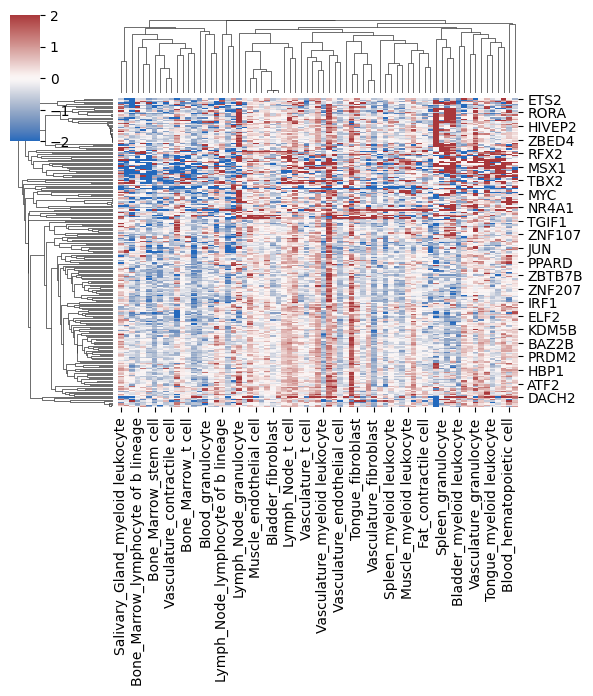

In [22]:
heatmap_df = all_chrX_exp.loc[genes_to_plot]
heatmap_df = heatmap_df.loc[genes_to_plot]

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure text remains as selectable text in PDF
mpl.rcParams['pdf.fonttype'] = 42   # TrueType fonts
mpl.rcParams['ps.fonttype'] = 42
# same for PS backend

# Your plotting code
plt.figure(figsize=(5,5),dpi=500)
g = sns.clustermap(
    heatmap_df,
    cmap='vlag',
    vmax=2,
    vmin=-2,
    figsize=(6,7),
    linewidths=0,
    xticklabels=3,
    yticklabels=10,
    row_cluster=True,
    col_cluster=True,
    metric='cosine'
)

plt.savefig("TF_sex.pdf", dpi=800, format="pdf")


In [26]:
# Ensure TF names and gene names match in format (e.g., uppercase)
TF_set = set(TF_list)

# Subset tissue-level sex-biased genes to those that are TFs
tf_df_tissue = TS_data_df_tissue[TS_data_df_tissue['gene'].isin(TF_set)].copy()


KeyError: 'gene'

In [27]:
# Create a binary matrix: rows = TFs, columns = tissues, value = 1 if sex-biased
tf_heatmap_df = pd.crosstab(tf_df_tissue['gene'], tf_df_tissue['tissue'])

# Optional: sort rows and columns
tf_heatmap_df = tf_heatmap_df.sort_index()
tf_heatmap_df = tf_heatmap_df[sorted(tf_heatmap_df.columns)]


NameError: name 'tf_df_tissue' is not defined

## Q1: categorise the sex-dependent genes that they identify into at least high-level groups 

Y-linked genes (Rhie et al., 2023, Nature)

genes that "escape" X chromosome inactivation (Tukiainen et al., 2017, Nature; Gylemo et al., 2024, bioRxiv)

estrogen-responsive genes (Harris et al., 2024, bioRxiv & many ER ChIP-seq papers)

androgen-responsive genes (Harris et al., 2024, bioRxiv & many AR ChIP-seq papers). 

In [23]:
df = pd.read_excel('chrx_inactivation.xlsx',header=1,index_col = 0)
df_escaope = df[df['Combined XCI status']=='escape']
df_partial = df[df['Combined XCI status']=='variable']


# from data directly
Y_linked_genes = TS_data_df[TS_data_df.type_new=='chrY'].index.unique()

# from Tukiainen et al., 2017, Nature
escape_chrx_inactivation = np.intersect1d(df_escaope.index,TS_data_df.index)
pescape_chrx_inactivation = np.intersect1d(df_partial.index,TS_data_df.index)

In [24]:
X_linked_genes = TS_data_df[TS_data_df.type_new=='chrX'].index.unique()


In [25]:
'SRY' in adata_tissue.var_names

True

In [26]:
adata_tissue[adata_tissue.obs['sex']=='female'][:,'UTY'].X.mean()

0.0006947112

In [27]:
adata_tissue[adata_tissue.obs['sex']=='male'][:,'UTY'].X.mean()

0.6669598

In [28]:
Y_linked_genes

Index(['DDX3Y', 'RPS4Y1', 'UTY', 'USP9Y', 'PRKY', 'TXLNGY', 'EIF1AY', 'KDM5D',
       'ZFY', 'TTTY14', 'LINC00278', 'ZFY-AS1', 'BCORP1', 'CASKP1', 'ANOS2P',
       'TTTY10', 'ENSG00000289826', 'ENSG00000289707', 'GYG2P1', 'NLGN4Y',
       'TBL1Y', 'ENSG00000286201', 'TMSB4Y', 'ENSG00000286009', 'ARSDP1',
       'ENSG00000273906', 'PSMA6P1', 'CDY4P', 'ZNF736P9Y', 'PCDH11Y',
       'ENSG00000286050', 'XGY2', 'ENSG00000260197', 'ENSG00000278847',
       'ENSG00000288049', 'ENSG00000229308', 'RPS4Y2', 'ENSG00000226918',
       'XGY1', 'OFD1P12Y', 'LINC00279', 'ENSG00000286247', 'RBMY2JP',
       'ENSG00000278212', 'VDAC1P6', 'ENSG00000286130'],
      dtype='object')

In [29]:
# from: https://academic.oup.com/mend/article/18/2/402/2747525
# https://genomebiology.biomedcentral.com/articles/10.1186/gb-2004-5-9-r66
# https://www.sciencedirect.com/science/article/pii/S0021925820615939
estrogen_responsive_genes = np.intersect1d(['E2IG4', 'IGFBP4',
                                            'B4GALT1', 'SLC2A1','GLUT1' ,
                                            'NRIP1','GREB1','ABCA3',
                                            'XBP1','EBAG9', 'OXT', 
                                            'F12', 'TFF1', 'LTF', 'CTSD', 
                                            'PFDN2', 'TGFA', 'AGT', 'GREB1',
                                            "ABAT","ABCA3","ABHD2","ABLIM1","ADCY1",
                                            "ADCY9","ADD3","AFF1","AKAP1","ALDH3B1",
                                            "AMFR","ANXA9","AQP3","AR","AREG","ARL3",
                                            "ASB13","B4GALT1","BAG1","BCL11B","BCL2",
                                            "BHLHE40","BLVRB","CA12","CALB2","CALCR",
                                            "CANT1","CBFA2T3","CCN5","CCND1","CD44",
                                            "CELSR1","CELSR2","CHPT1","CISH","CLDN7",
                                            "CLIC3","CXCL12","CYP26B1","DEPTOR","DHCR7",
                                            "DHRS2","DHRS3","DLC1","DYNLT3","EEIG1","EGR3",
                                            "ELF1","ELF3","ELOVL2","ELOVL5","ENDOD1","ESRP2",
                                            "FARP1","FASN","FCMR","FDFT1","FHL2","FKBP4",
                                            "FKBP5","FLNB","FOS","FOXC1","FRK","GAB2","GFRA1",
                                            "GJA1","GLA","GREB1","HES1","HR","HSPB8","IGF1R",
                                            "IGFBP4","IL17RB","IL6ST","INHBB","INPP5F","ISG20L2",
                                            "ITPK1","JAK2","KAZN","KCNK15","KCNK5","KDM4B","KLF10",
                                            "KLF4","KLK10","KRT13","KRT15","KRT18","KRT19","KRT8",
                                            "LAD1","LRIG1","MAPT","MAST4","MED13L","MED24","MICB",
                                            "MINDY1","MLPH","MPPED2","MREG","MSMB","MUC1","MYB",
                                            "MYBBP1A","MYBL1","MYC","MYOF","NADSYN1","NAV2","NBL1",
                                            "NCOR2","NHERF1","NPY1R","NRIP1","NXT1","OLFM1","OLFML3",
                                            "OPN3","OVOL2","P2RY2","PAPSS2","PDLIM3","PDZK1","PEX11A",
                                            "PGR","PLAAT3","PMAIP1","PODXL","PPIF","PRSS23",
                                            "PTGES","RAB17","RAB31","RAPGEFL1","RARA","RASGRP1",
                                            "RBBP8","REEP1","RET","RETREG1","RHOBTB3","RHOD",
                                            "RPS6KA2","RRP12","SCARB1","SCNN1A","SEC14L2","SEMA3B",
                                            "SFN","SH3BP5","SIAH2","SLC16A1","SLC19A2","SLC1A1","SLC1A4",
                                            "SLC22A5","SLC24A3","SLC26A2","SLC27A2","SLC2A1","SLC37A1",
                                            "SLC39A6","SLC7A2","SLC7A5","SNX24","SOX3","STC2","SULT2B1",
                                            "SVIL","SYBU","SYNGR1","SYT12","TBC1D30","TFAP2C","TFF1",
                                            "TFF3","TGIF2","TGM2","THSD4","TIAM1","TIPARP","TJP3",
                                            "TMEM164","TMPRSS3","TOB1","TPBG","TPD52L1","TSKU","TTC39A",
                                            "TUBB2B","UGCG","UNC119","WFS1","WWC1","XBP1","ZNF185"
                                           ], TS_data_df.index)
estrogen_responsive_genes

array(['AFF1', 'ALDH3B1', 'AR', 'AREG', 'B4GALT1', 'BCL2', 'BLVRB',
       'CHPT1', 'CTSD', 'CXCL12', 'DHRS3', 'ELF1', 'ELOVL5', 'FCMR',
       'FDFT1', 'FKBP4', 'FKBP5', 'FOS', 'GAB2', 'GJA1', 'GLA', 'HES1',
       'IGF1R', 'IL6ST', 'INPP5F', 'JAK2', 'KLF10', 'KLF4', 'KRT13',
       'MED13L', 'MREG', 'MYBL1', 'MYC', 'NRIP1', 'PAPSS2', 'PFDN2',
       'PLAAT3', 'PPIF', 'RHOBTB3', 'RPS6KA2', 'SCARB1', 'SH3BP5',
       'SIAH2', 'SLC24A3', 'SLC7A5', 'SNX24', 'SVIL', 'TGFA', 'TGM2',
       'TIAM1', 'TMEM164', 'TOB1', 'UGCG', 'XBP1'], dtype=object)

In [30]:
# GSEA
androgen_responsive_genes = np.intersect1d(['KLK3', 'PSA',
                                            'KLK2', 'NKX3-1','NKX3',"ABCC4","ABHD2","ACSL3","ACTN1","ADAMTS1","ADRM1",
                                                                     "AKAP12","AKT1","ALDH1A3","ANKH","APPBP2","ARID5B","AZGP1"
                                                                     "B2M","B4GALT1","BMPR1B","CAMKK2","CCND1","CCND3","CDC14B",
                                                                     "CDK6","CENPN","DBI","DHCR24","DNAJB9","ELK4","ELL2","ELOVL5",
                                                                     "FADS1","FKBP5","GNAI3","GPD1L","GSR","GUCY1A1","H1-0","HERC3",
                                                                     "HMGCR","HMGCS1","HOMER2","HPGD","HSD17B14","IDI1","INPP4B","INSIG1",
                                                                     "IQGAP2","ITGAV","KLK2","KLK3","KRT19","KRT8","LIFR","LMAN1","MAF",
                                                                     "MAK","MAP7","MERTK","MYL12A","NCOA4","NDRG1","NGLY1","NKX3-1",
                                                                     "PA2G4","PDLIM5","PGM3","PIAS1","PLPP1","PMEPA1","PTK2B","PTPN21",
                                                                     "RAB4A","RPS6KA3","RRP12","SAT1","SCD","SEC24D","SELENOP","SGK1",
                                                                     "SLC26A2","SLC38A2","SMS","SORD","SPCS3","SPDEF","SRF","SRP19","STEAP4",
                                                                     "STK39","TARP","TMEM50A","TMPRSS2","TNFAIP8","TPD52","TSC22D1","UAP1",
                                                                     "UBE2I","UBE2J1","VAPA","XRCC5","XRCC6","ZBTB10","ZMIZ1"
                                            ], TS_data_df.index)
androgen_responsive_genes

array(['ABCC4', 'ACSL3', 'ACTN1', 'ARID5B', 'B4GALT1', 'CCND3', 'CDK6',
       'DBI', 'DNAJB9', 'ELL2', 'ELOVL5', 'FKBP5', 'GNAI3', 'GPD1L',
       'GSR', 'GUCY1A1', 'H1-0', 'HMGCR', 'HMGCS1', 'HPGD', 'INPP4B',
       'INSIG1', 'IQGAP2', 'ITGAV', 'MAF', 'MYL12A', 'NGLY1', 'PTK2B',
       'SAT1', 'SCD', 'SELENOP', 'SGK1', 'SLC38A2', 'SMS', 'TNFAIP8'],
      dtype=object)

In [31]:
all_chrX_exp

Bladder_contractile cell  Bladder_endothelial cell  \
DDX3Y                  -41.123163                -41.501906   
RPS4Y1                 -12.576012                -41.338222   
XIST                     9.425566                 42.614315   
UTY                    -11.405141                -40.069780   
USP9Y                  -10.902375                 -8.015415   
...                           ...                       ...   
CRTAC1                   1.387023                 38.083880   
ZBTB18                  -0.794416                  0.366597   
PSENEN                  -0.011874                  0.907685   
CTNNAL1                 -0.091519                  0.437318   
MCC                     -0.101751                  0.845829   

         Bladder_fibroblast  Bladder_granulocyte  Bladder_myeloid leukocyte  \
DDX3Y            -41.629944           -39.555564                 -42.699869   
RPS4Y1           -42.483020           -39.986141                 -11.068106   
XIST              41.719725            40.804243                  41.990110   
UTY              -11.227616           -39.283215                 -41.062888   
USP9Y             -9.339850           -37.077262                  -9.178665   
...                     ...                  ...                        ...   
CRTAC1             0.060754             0.000000                 -32.704708   
ZBTB18            -1.485427            -1.781360                  -0.855265   
PSENEN            -0.114664             1.298081                  -0.311944   
CTNNAL1           -0.560578            -0.152003                  -0.520390   
MCC               -0.076460             1.699579                  -0.900464   

         Bladder_t cell  Bladder_transitional epithelial cell  \
DDX3Y        -40.105587                            -41.602985   
RPS4Y1       -40.966131                            -12.626317   
XIST          40.560466                             42.905606   
UTY          -11.246741                            -10.461479   
USP9Y         -9.773139                            -10.700440   
...                 ...                                   ...   
CRTAC1         0.000000                             -1.645264   
ZBTB18        -0.811928                             -0.976730   
PSENEN        -0.916744                             -0.482049   
CTNNAL1       -0.004692                             -0.545486   
MCC            0.425551                             -0.425036   

         Blood_erythroid lineage cell  Blood_granulocyte  \
DDX3Y                      -33.219281         -38.182755   
RPS4Y1                     -35.254905         -36.191974   
XIST                        32.662888          37.747019   
UTY                        -32.704708          -8.821933   
USP9Y                        0.000000          -3.584963   
...                               ...                ...   
CRTAC1                      30.897353           0.000000   
ZBTB18                      -0.099536          -0.290342   
PSENEN                      -2.247928           0.048499   
CTNNAL1                     -0.095780           0.479168   
MCC                          0.000000          -1.672425   

         Blood_hematopoietic cell  ...  Trachea_endothelial cell  \
DDX3Y                  -38.246081  ...                -40.741274   
RPS4Y1                 -40.506532  ...                 -9.738303   
XIST                    40.020612  ...                 42.725489   
UTY                     -8.689998  ...                 -6.960002   
USP9Y                   -8.264443  ...                 -5.472783   
...                           ...  ...                       ...   
CRTAC1                  31.312390  ...                  1.046294   
ZBTB18                  -0.150560  ...                 -2.099256   
PSENEN                  -0.097847  ...                 -0.115477   
CTNNAL1                  0.915058  ...                 -0.367128   
MCC                      0.000000  ...               

<Figure size 3200x2400 with 0 Axes>

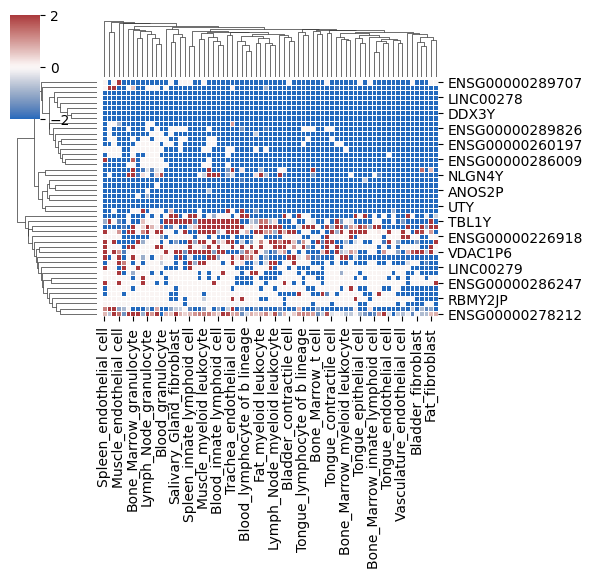

In [54]:
import seaborn as sns

categories = {
    "Y_linked_genes": list(Y_linked_genes),
    #"Escape_chrX_inactivation": list(escape_chrx_inactivation),
    #"Estrogen_responsive_genes": list(estrogen_responsive_genes),
    #"Androgen_responsive_genes": list(androgen_responsive_genes)
}

gene_category_map = {}
for cat, genes in categories.items():
    for gene in genes:
        gene_category_map[gene] = cat
genes_to_plot = [gene for gene in all_chrX_exp.index if gene in gene_category_map]
heatmap_df = all_chrX_exp.loc[genes_to_plot]
heatmap_df = heatmap_df.loc[genes_to_plot]


row_colors = pd.DataFrame(
    heatmap_df.index.map(gene_category_map), 
    index=heatmap_df.index, 
    columns=['Category']
)
category_colors = {
    'Y_linked_genes': '#4C72B0',
    'Escape_chrX_inactivation': '#55A868',
    'Estrogen_responsive_genes': '#C44E52',
    'Androgen_responsive_genes': '#8172B2'
}

row_colors['Category'] = row_colors['Category'].map(category_colors)

#heatmap_zscore = heatmap_df.subtract(heatmap_df.mean(axis=1), axis=0).divide(heatmap_df.std(axis=1), axis=0)
plt.figure(dpi=500)
g = sns.clustermap(
    heatmap_df,
    cmap='vlag',
    vmax=2,
    vmin=-2,
    #row_colors=row_colors['Category'],
    figsize=(6,5.8),
    linewidths=.5,
    xticklabels=3,
    yticklabels=3,
    row_cluster=True,  
    col_cluster=True  
)

for category, color in category_colors.items():
    g.ax_row_dendrogram.bar(0, 0, color=color, label=category, linewidth=0)
#g.ax_row_dendrogram.legend(title='Gene Categories', loc='center', ncol=1)

plt.savefig('R1-Ylinked.pdf',dpi=800,format='pdf')


<Figure size 3200x2400 with 0 Axes>

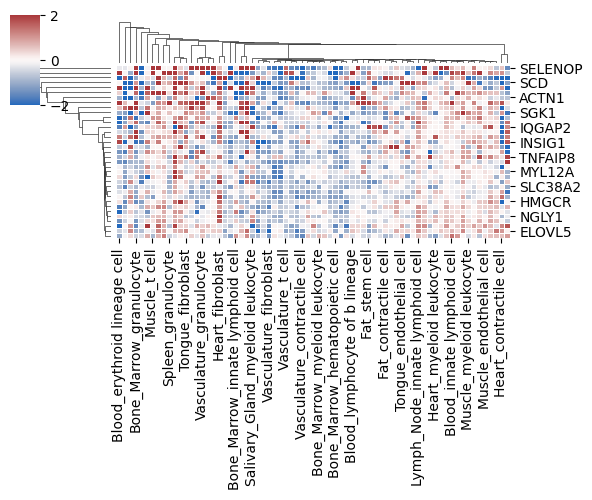

In [45]:
import seaborn as sns

categories = {
    #"Y_linked_genes": list(Y_linked_genes),
    #"Escape_chrX_inactivation": list(escape_chrx_inactivation),
    #"Estrogen_responsive_genes": list(estrogen_responsive_genes),
    "Androgen_responsive_genes": list(androgen_responsive_genes)
}

gene_category_map = {}
for cat, genes in categories.items():
    for gene in genes:
        gene_category_map[gene] = cat
genes_to_plot = [gene for gene in all_chrX_exp.index if gene in gene_category_map]
heatmap_df = all_chrX_exp.loc[genes_to_plot]
heatmap_df = heatmap_df.loc[genes_to_plot]


row_colors = pd.DataFrame(
    heatmap_df.index.map(gene_category_map), 
    index=heatmap_df.index, 
    columns=['Category']
)
category_colors = {
    'Y_linked_genes': '#4C72B0',
    'Escape_chrX_inactivation': '#55A868',
    'Estrogen_responsive_genes': '#C44E52',
    'Androgen_responsive_genes': '#8172B2'
}

row_colors['Category'] = row_colors['Category'].map(category_colors)

#heatmap_zscore = heatmap_df.subtract(heatmap_df.mean(axis=1), axis=0).divide(heatmap_df.std(axis=1), axis=0)
plt.figure(dpi=500)
g = sns.clustermap(
    heatmap_df,
    cmap='vlag',
    vmax=2,
    vmin=-2,
    #row_colors=row_colors['Category'],
    figsize=(6,5),
    linewidths=.5,
    xticklabels=3,
    yticklabels=3,
    row_cluster=True,  
    col_cluster=True  
)

for category, color in category_colors.items():
    g.ax_row_dendrogram.bar(0, 0, color=color, label=category, linewidth=0)
#g.ax_row_dendrogram.legend(title='Gene Categories', loc='center', ncol=1)

plt.savefig('R1-Androgen_responsive_genes.pdf',dpi=800,format='pdf')


<Figure size 3200x2400 with 0 Axes>

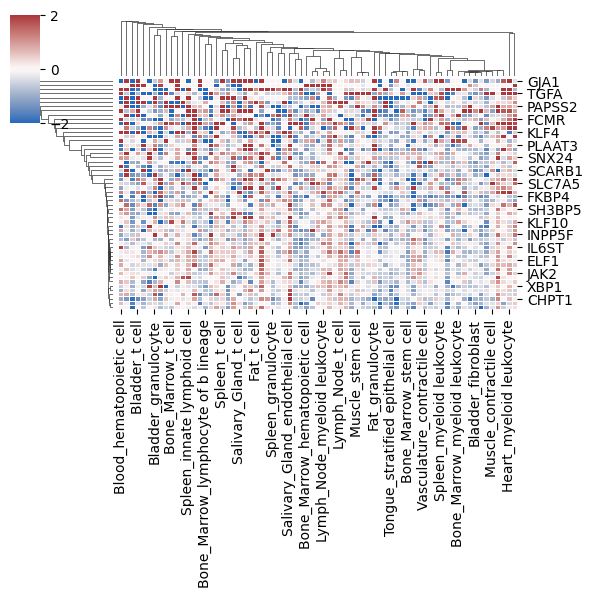

In [53]:
import seaborn as sns

categories = {
    #"Y_linked_genes": list(Y_linked_genes),
    #"Escape_chrX_inactivation": list(escape_chrx_inactivation),
    "Estrogen_responsive_genes": list(estrogen_responsive_genes),
    #"Androgen_responsive_genes": list(androgen_responsive_genes)
}

gene_category_map = {}
for cat, genes in categories.items():
    for gene in genes:
        gene_category_map[gene] = cat
genes_to_plot = [gene for gene in all_chrX_exp.index if gene in gene_category_map]
heatmap_df = all_chrX_exp.loc[genes_to_plot]
heatmap_df = heatmap_df.loc[genes_to_plot]


row_colors = pd.DataFrame(
    heatmap_df.index.map(gene_category_map), 
    index=heatmap_df.index, 
    columns=['Category']
)
category_colors = {
    'Y_linked_genes': '#4C72B0',
    'Escape_chrX_inactivation': '#55A868',
    'Estrogen_responsive_genes': '#C44E52',
    'Androgen_responsive_genes': '#8172B2'
}

row_colors['Category'] = row_colors['Category'].map(category_colors)

#heatmap_zscore = heatmap_df.subtract(heatmap_df.mean(axis=1), axis=0).divide(heatmap_df.std(axis=1), axis=0)
plt.figure(dpi=500)
g = sns.clustermap(
    heatmap_df,
    cmap='vlag',
    vmax=2,
    vmin=-2,
    #row_colors=row_colors['Category'],
    figsize=(6,6),
    linewidths=.5,
    xticklabels=3,
    yticklabels=3,
    row_cluster=True,  
    col_cluster=True  
)

for category, color in category_colors.items():
    g.ax_row_dendrogram.bar(0, 0, color=color, label=category, linewidth=0)
#g.ax_row_dendrogram.legend(title='Gene Categories', loc='center', ncol=1)

plt.savefig('R1-Estrogen_responsive_genes.pdf',dpi=800,format='pdf')


<Figure size 3200x2400 with 0 Axes>

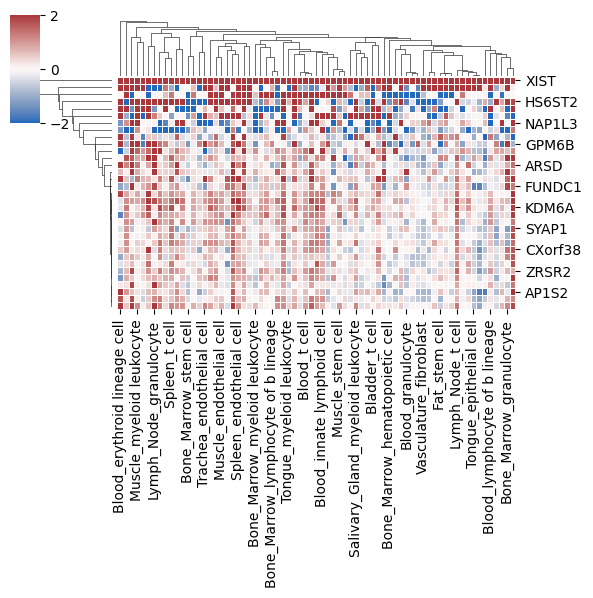

In [55]:
import seaborn as sns

categories = {
    #"Y_linked_genes": list(Y_linked_genes),
    "Escape_chrX_inactivation": list(escape_chrx_inactivation),
    #"Estrogen_responsive_genes": list(estrogen_responsive_genes),
    #"Androgen_responsive_genes": list(androgen_responsive_genes)
}

gene_category_map = {}
for cat, genes in categories.items():
    for gene in genes:
        gene_category_map[gene] = cat
genes_to_plot = [gene for gene in all_chrX_exp.index if gene in gene_category_map]
heatmap_df = all_chrX_exp.loc[genes_to_plot]
heatmap_df = heatmap_df.loc[genes_to_plot]


row_colors = pd.DataFrame(
    heatmap_df.index.map(gene_category_map), 
    index=heatmap_df.index, 
    columns=['Category']
)
category_colors = {
    'Y_linked_genes': '#4C72B0',
    'Escape_chrX_inactivation': '#55A868',
    'Estrogen_responsive_genes': '#C44E52',
    'Androgen_responsive_genes': '#8172B2'
}

row_colors['Category'] = row_colors['Category'].map(category_colors)

#heatmap_zscore = heatmap_df.subtract(heatmap_df.mean(axis=1), axis=0).divide(heatmap_df.std(axis=1), axis=0)
plt.figure(dpi=500)
g = sns.clustermap(
    heatmap_df,
    cmap='vlag',
    vmax=2,
    vmin=-2,
    #row_colors=row_colors['Category'],
    figsize=(6,6),
    linewidths=.5,
    xticklabels=3,
    yticklabels=3,
    row_cluster=True,  
    col_cluster=True  
)

for category, color in category_colors.items():
    g.ax_row_dendrogram.bar(0, 0, color=color, label=category, linewidth=0)
#g.ax_row_dendrogram.legend(title='Gene Categories', loc='center', ncol=1)

plt.savefig('R1-Escape_chrX_inactivation.pdf',dpi=800,format='pdf')


<Figure size 3200x2400 with 0 Axes>

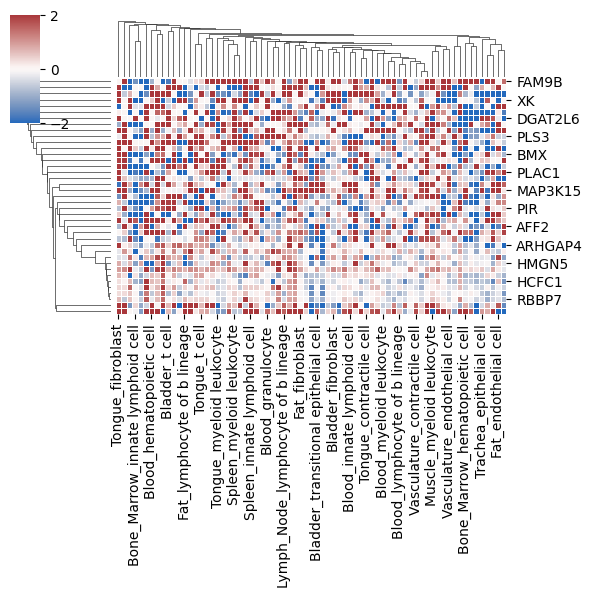

In [56]:
import seaborn as sns

categories = {
    #"Y_linked_genes": list(Y_linked_genes),
    "Escape_chrX_inactivation": list(pescape_chrx_inactivation),
    #"Estrogen_responsive_genes": list(estrogen_responsive_genes),
    #"Androgen_responsive_genes": list(androgen_responsive_genes)
}

gene_category_map = {}
for cat, genes in categories.items():
    for gene in genes:
        gene_category_map[gene] = cat
genes_to_plot = [gene for gene in all_chrX_exp.index if gene in gene_category_map]
heatmap_df = all_chrX_exp.loc[genes_to_plot]
heatmap_df = heatmap_df.loc[genes_to_plot]


row_colors = pd.DataFrame(
    heatmap_df.index.map(gene_category_map), 
    index=heatmap_df.index, 
    columns=['Category']
)
category_colors = {
    'Y_linked_genes': '#4C72B0',
    'Escape_chrX_inactivation': '#55A868',
    'Estrogen_responsive_genes': '#C44E52',
    'Androgen_responsive_genes': '#8172B2'
}

row_colors['Category'] = row_colors['Category'].map(category_colors)

#heatmap_zscore = heatmap_df.subtract(heatmap_df.mean(axis=1), axis=0).divide(heatmap_df.std(axis=1), axis=0)
plt.figure(dpi=500)
g = sns.clustermap(
    heatmap_df,
    cmap='vlag',
    vmax=2,
    vmin=-2,
    #row_colors=row_colors['Category'],
    figsize=(6,6),
    linewidths=.5,
    xticklabels=3,
    yticklabels=3,
    row_cluster=True,  
    col_cluster=True  
)

for category, color in category_colors.items():
    g.ax_row_dendrogram.bar(0, 0, color=color, label=category, linewidth=0)
#g.ax_row_dendrogram.legend(title='Gene Categories', loc='center', ncol=1)

plt.savefig('R1-Escape_chrX_pinactivation.pdf',dpi=800,format='pdf')


<Figure size 3200x2400 with 0 Axes>

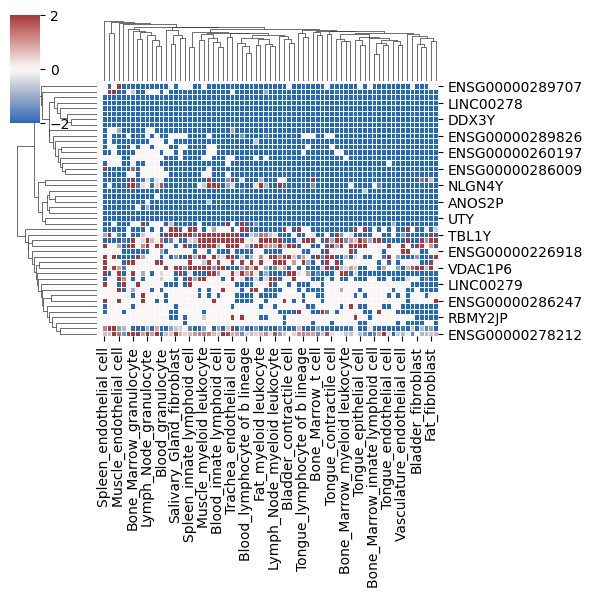

In [57]:
import seaborn as sns

categories = {
    "Y_linked_genes": list(Y_linked_genes),
    #"Escape_chrX_inactivation": list(escape_chrx_inactivation),
    #"Estrogen_responsive_genes": list(estrogen_responsive_genes),
    #"Androgen_responsive_genes": list(androgen_responsive_genes)
}

gene_category_map = {}
for cat, genes in categories.items():
    for gene in genes:
        gene_category_map[gene] = cat
genes_to_plot = [gene for gene in all_chrX_exp.index if gene in gene_category_map]
heatmap_df = all_chrX_exp.loc[genes_to_plot]
heatmap_df = heatmap_df.loc[genes_to_plot]


row_colors = pd.DataFrame(
    heatmap_df.index.map(gene_category_map), 
    index=heatmap_df.index, 
    columns=['Category']
)
category_colors = {
    'Y_linked_genes': '#4C72B0',
    'Escape_chrX_inactivation': '#55A868',
    'Estrogen_responsive_genes': '#C44E52',
    'Androgen_responsive_genes': '#8172B2'
}

row_colors['Category'] = row_colors['Category'].map(category_colors)

#heatmap_zscore = heatmap_df.subtract(heatmap_df.mean(axis=1), axis=0).divide(heatmap_df.std(axis=1), axis=0)
plt.figure(dpi=500)
g = sns.clustermap(
    heatmap_df,
    cmap='vlag',
    vmax=2,
    vmin=-2,
    #row_colors=row_colors['Category'],
    figsize=(6,6),
    linewidths=.5,
    xticklabels=3,
    yticklabels=3,
    row_cluster=True,  
    col_cluster=True  
)

for category, color in category_colors.items():
    g.ax_row_dendrogram.bar(0, 0, color=color, label=category, linewidth=0)
#g.ax_row_dendrogram.legend(title='Gene Categories', loc='center', ncol=1)

plt.savefig('R1-Ylinked.pdf',dpi=800,format='pdf')


<Figure size 3200x2400 with 0 Axes>

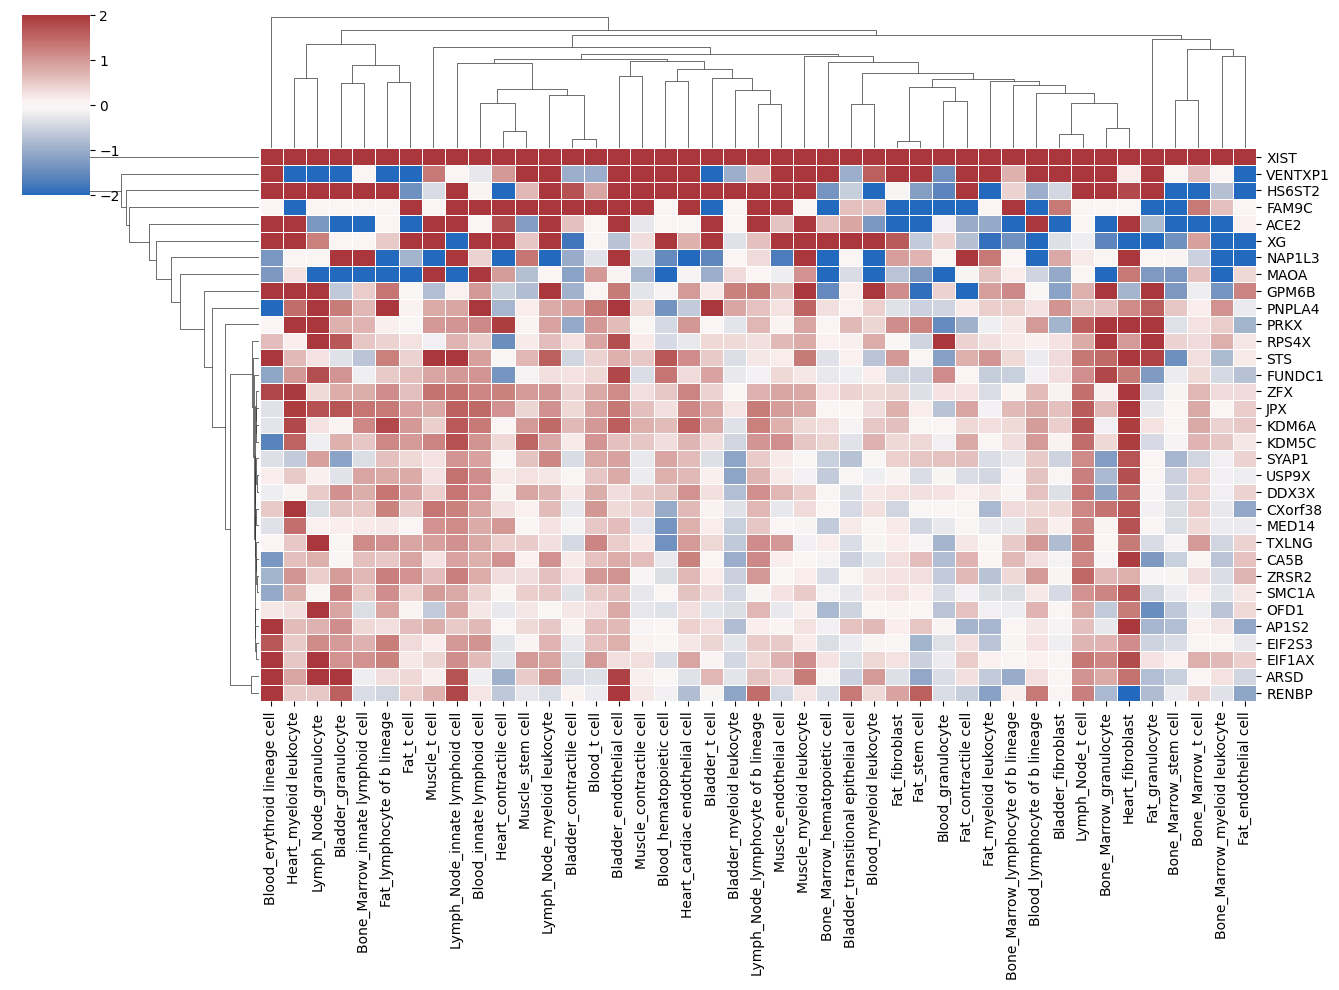

In [140]:
import seaborn as sns

categories = {
    #"Y_linked_genes": list(Y_linked_genes),
    "Escape_chrX_inactivation": list(escape_chrx_inactivation),
    #"Estrogen_responsive_genes": list(estrogen_responsive_genes),
    #"Androgen_responsive_genes": list(androgen_responsive_genes)
}

gene_category_map = {}
for cat, genes in categories.items():
    for gene in genes:
        gene_category_map[gene] = cat
genes_to_plot = [gene for gene in all_chrX_exp.index if gene in gene_category_map]
heatmap_df = all_chrX_exp.loc[genes_to_plot]
heatmap_df = heatmap_df.loc[genes_to_plot]


row_colors = pd.DataFrame(
    heatmap_df.index.map(gene_category_map), 
    index=heatmap_df.index, 
    columns=['Category']
)
category_colors = {
    'Y_linked_genes': '#4C72B0',
    'Escape_chrX_inactivation': '#55A868',
    'Estrogen_responsive_genes': '#C44E52',
    'Androgen_responsive_genes': '#8172B2'
}

row_colors['Category'] = row_colors['Category'].map(category_colors)

#heatmap_zscore = heatmap_df.subtract(heatmap_df.mean(axis=1), axis=0).divide(heatmap_df.std(axis=1), axis=0)
plt.figure(dpi=500)
g = sns.clustermap(
    heatmap_df,
    cmap='vlag',
    vmax=2,
    vmin=-2,
    #row_colors=row_colors['Category'],
    figsize=(13.5,10),
    linewidths=.5,
    xticklabels=True,
    yticklabels=True,
    row_cluster=True,  
    col_cluster=True  
)

for category, color in category_colors.items():
    g.ax_row_dendrogram.bar(0, 0, color=color, label=category, linewidth=0)
#g.ax_row_dendrogram.legend(title='Gene Categories', loc='center', ncol=1)

plt.savefig('R1-1.pdf',dpi=800,format='pdf')


##  Q2: 


In [289]:
# first get the <1% FDR genes: 
TS_data_df_XCI = edgeR_LRT_all
TS_data_df_tissue_XCI = edgeR_LRT_all_tissue

TS_data_df_XCI = TS_data_df_XCI[TS_data_df_XCI.tissue!='Thymus'].copy()
TS_data_df_tissue_XCI = TS_data_df_tissue_XCI[TS_data_df_tissue_XCI.tissue!='Thymus'].copy()

TS_data_df_XCI = TS_data_df_XCI[TS_data_df_XCI['FDR']<0.005  ]
TS_data_df_tissue_XCI = TS_data_df_tissue_XCI[TS_data_df_tissue_XCI['FDR']<0.005]

TS_data_df_XCI['tissue_cell_type'] = TS_data_df_XCI['tissue']+'_'+TS_data_df_XCI['cell_type']

In [290]:
# Step1: collect robust XCI genes:
# https://www.nature.com/articles/nature24265
# We show that XCI at 683 X-chromosomal genes is generally uniform across human tissues, 
# but identify examples of heterogeneity between tissues, individuals and cells.

XCI_genes = pd.read_excel('chrx_inactivation.xlsx',header=1,index_col = 0)
XCI_genes.index.unique().shape


(631,)

In [300]:
num_dict = {}
for xci_state in XCI_genes['Combined XCI status'].unique():
    print(xci_state)
    genes_ = XCI_genes[XCI_genes['Combined XCI status']==xci_state].index.astype(str)
    num_list = []
    for tissue_ in sorted(TS_data_df_XCI['cell_type'].unique()):
        inter_genes_ = set(np.intersect1d(list(genes_), 
                                          list(TS_data_df_XCI[TS_data_df_XCI['cell_type']==tissue_].index)))
        num_list.append(len(inter_genes_)/len(genes_)*100)
    num_dict[xci_state]=num_list

escape
variable
inactive


/tmp/ipykernel_3939240/4076943949.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

escape vs. variable: Mann-Whitney-Wilcoxon test two-sided, P_val:1.496e-01 U_stat=1.380e+02
escape vs. inactive: Mann-Whitney-Wilcoxon test two-sided, P_val:4.256e-02 U_stat=1.545e+02


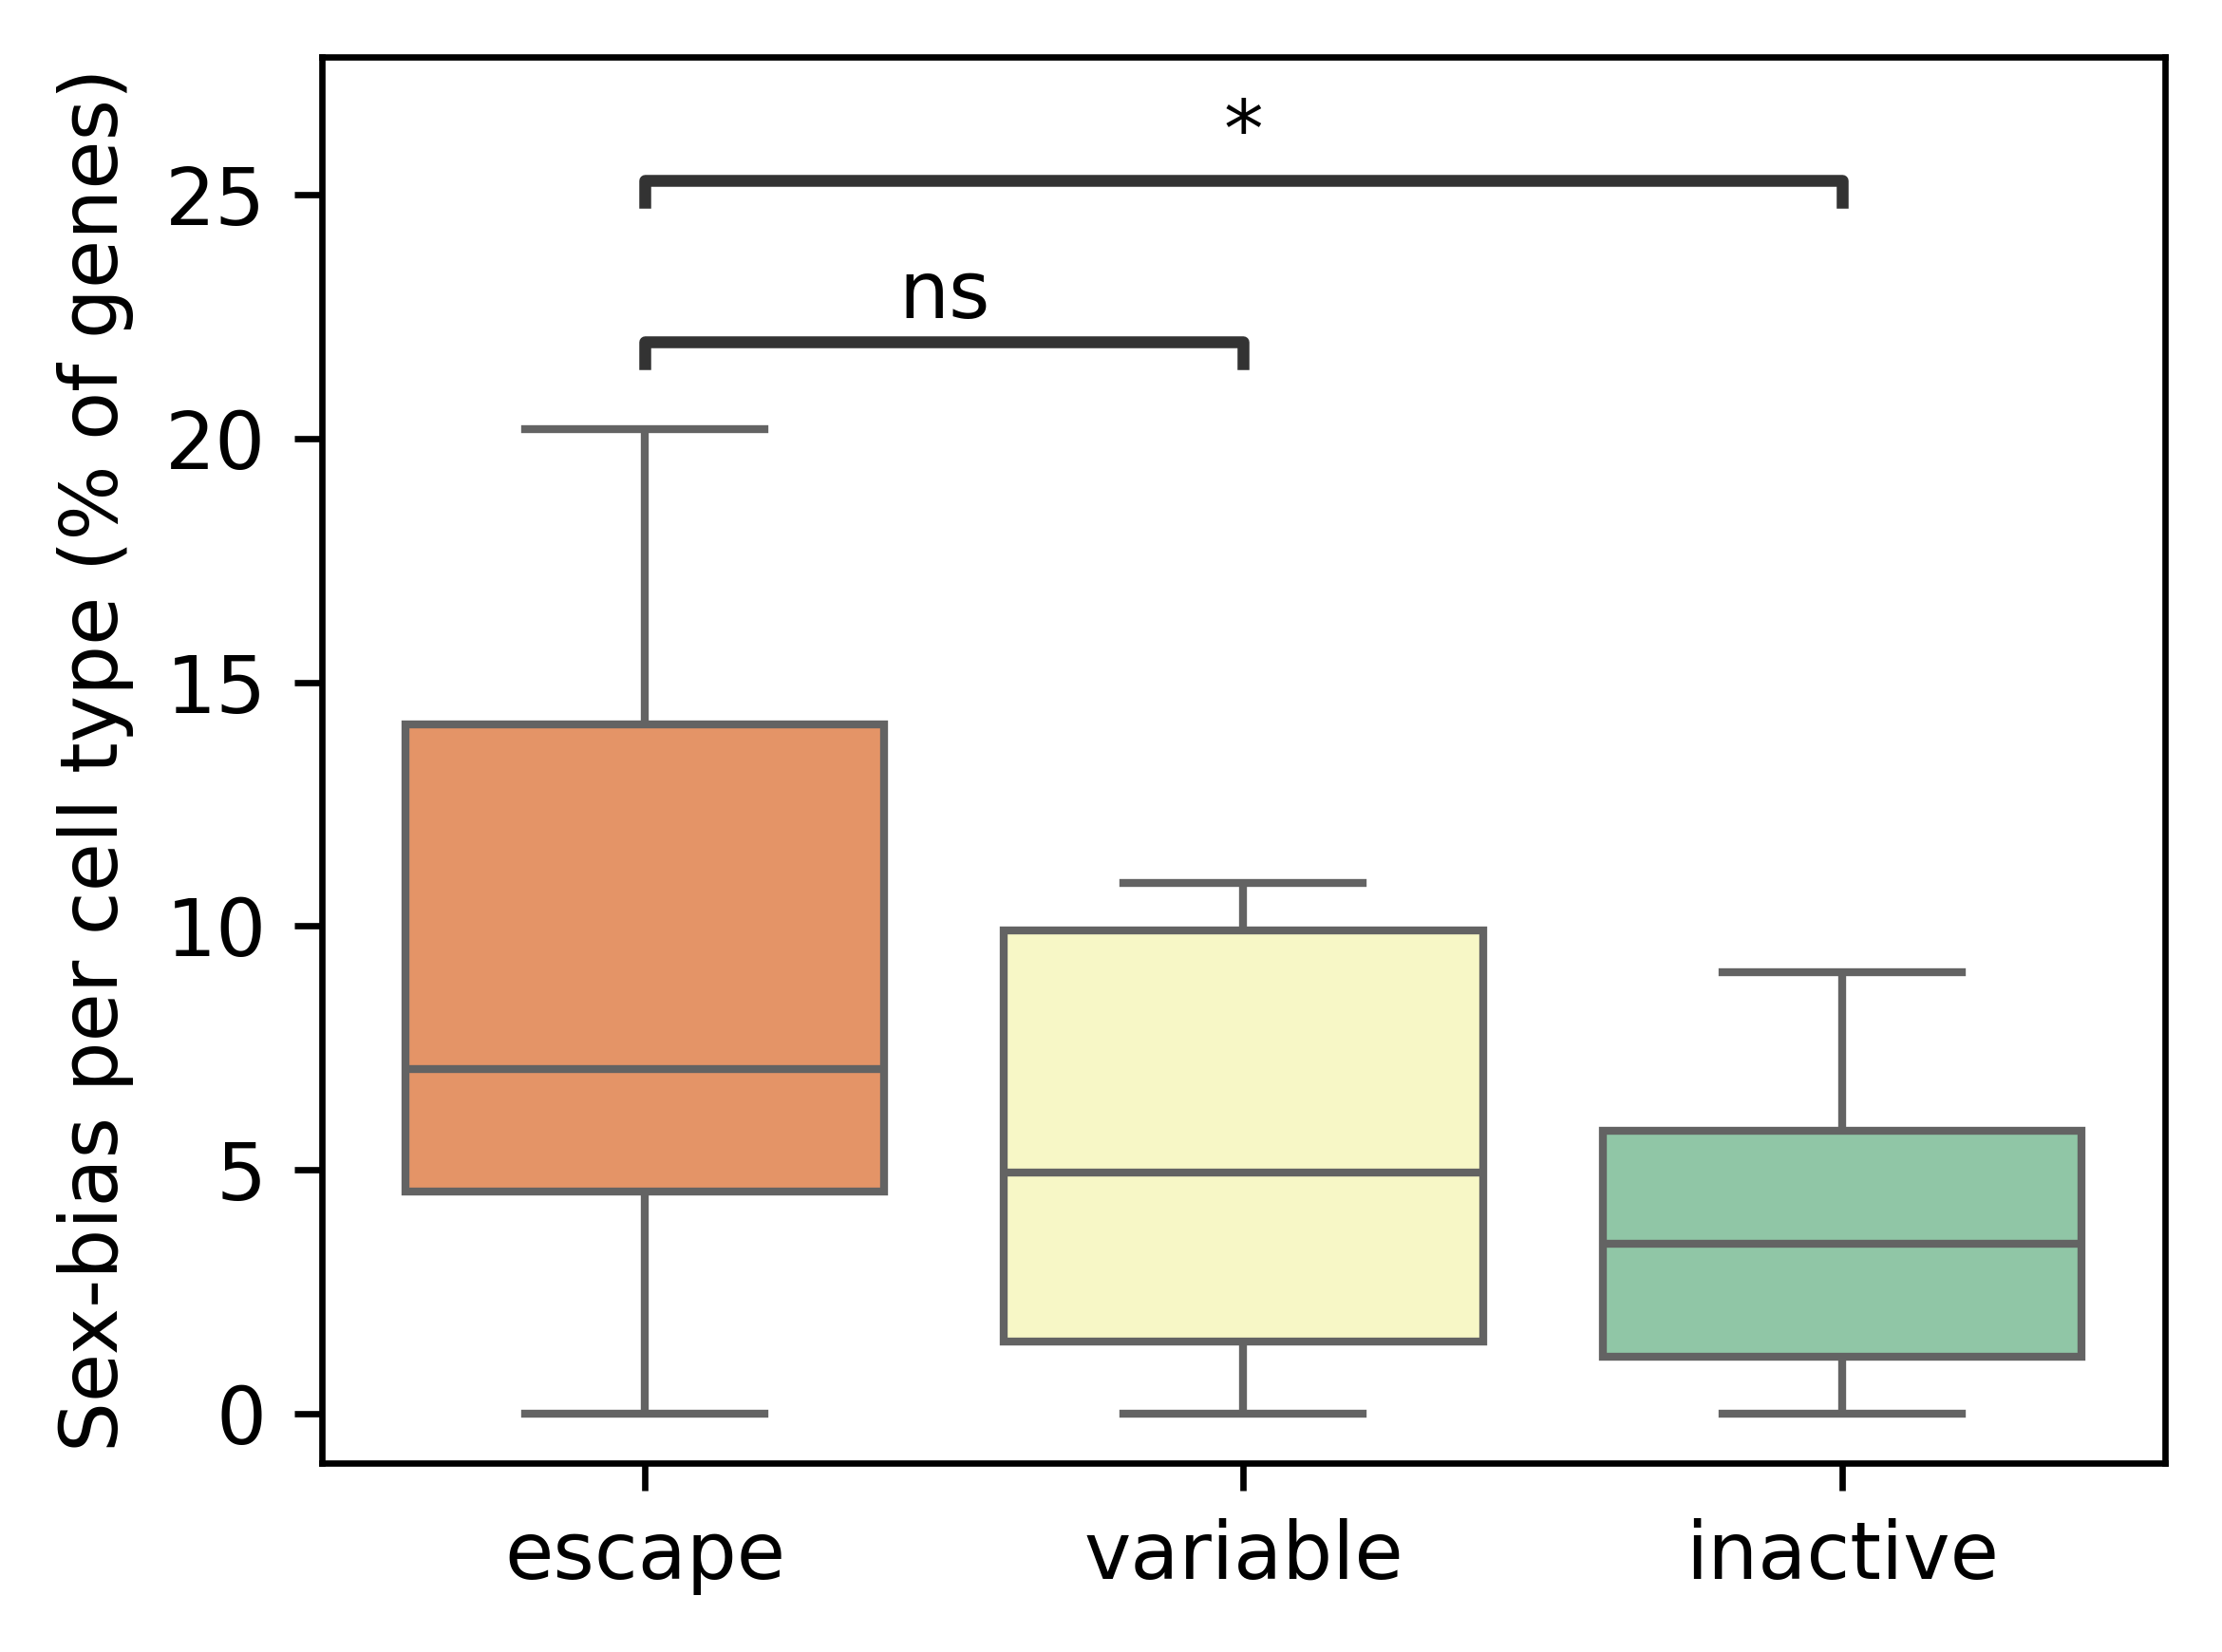

In [307]:
from statannotations.Annotator import Annotator

df_long = pd.melt(pd.DataFrame(num_dict), var_name='Category', value_name='Percentage')

plt.figure(figsize=(4,3),dpi=600)
g1=sns.boxplot(x='Category', y='Percentage', data=df_long, palette='Spectral',showfliers=False)

plt.ylabel('Sex-bias per cell type (% of genes)')
plt.xlabel('')

box_pairs = [
    ('escape','variable'),
    ('escape','inactive'),
            ]

annot = Annotator(g1, box_pairs, data=df_long, x='Category', y='Percentage',)
annot.configure(test='Mann-Whitney', verbose=2,text_format='star')
annot.apply_test(#equal_var=False,
                 alternative='greater'
                )
annot.annotate()


plt.tight_layout()
plt.savefig('R2-1.pdf',dpi=800,format='pdf')


In [302]:
num_dict = {}
for xci_state in XCI_genes['Combined XCI status'].unique():
    print(xci_state)
    genes_ = XCI_genes[XCI_genes['Combined XCI status']==xci_state].index.astype(str)
    num_list = []
    for tissue_ in sorted(TS_data_df_tissue_XCI['tissue'].unique()):
        inter_genes_ = set(np.intersect1d(list(genes_), 
                                          list(TS_data_df_tissue_XCI[TS_data_df_tissue_XCI['tissue']==tissue_].index)))
        num_list.append(len(inter_genes_)/len(genes_)*100)
    num_dict[xci_state]=num_list

escape
variable
inactive


/tmp/ipykernel_3939240/2194656985.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

escape vs. variable: Mann-Whitney-Wilcoxon test two-sided, P_val:1.514e-02 U_stat=1.100e+02
escape vs. inactive: Mann-Whitney-Wilcoxon test two-sided, P_val:1.307e-02 U_stat=1.110e+02


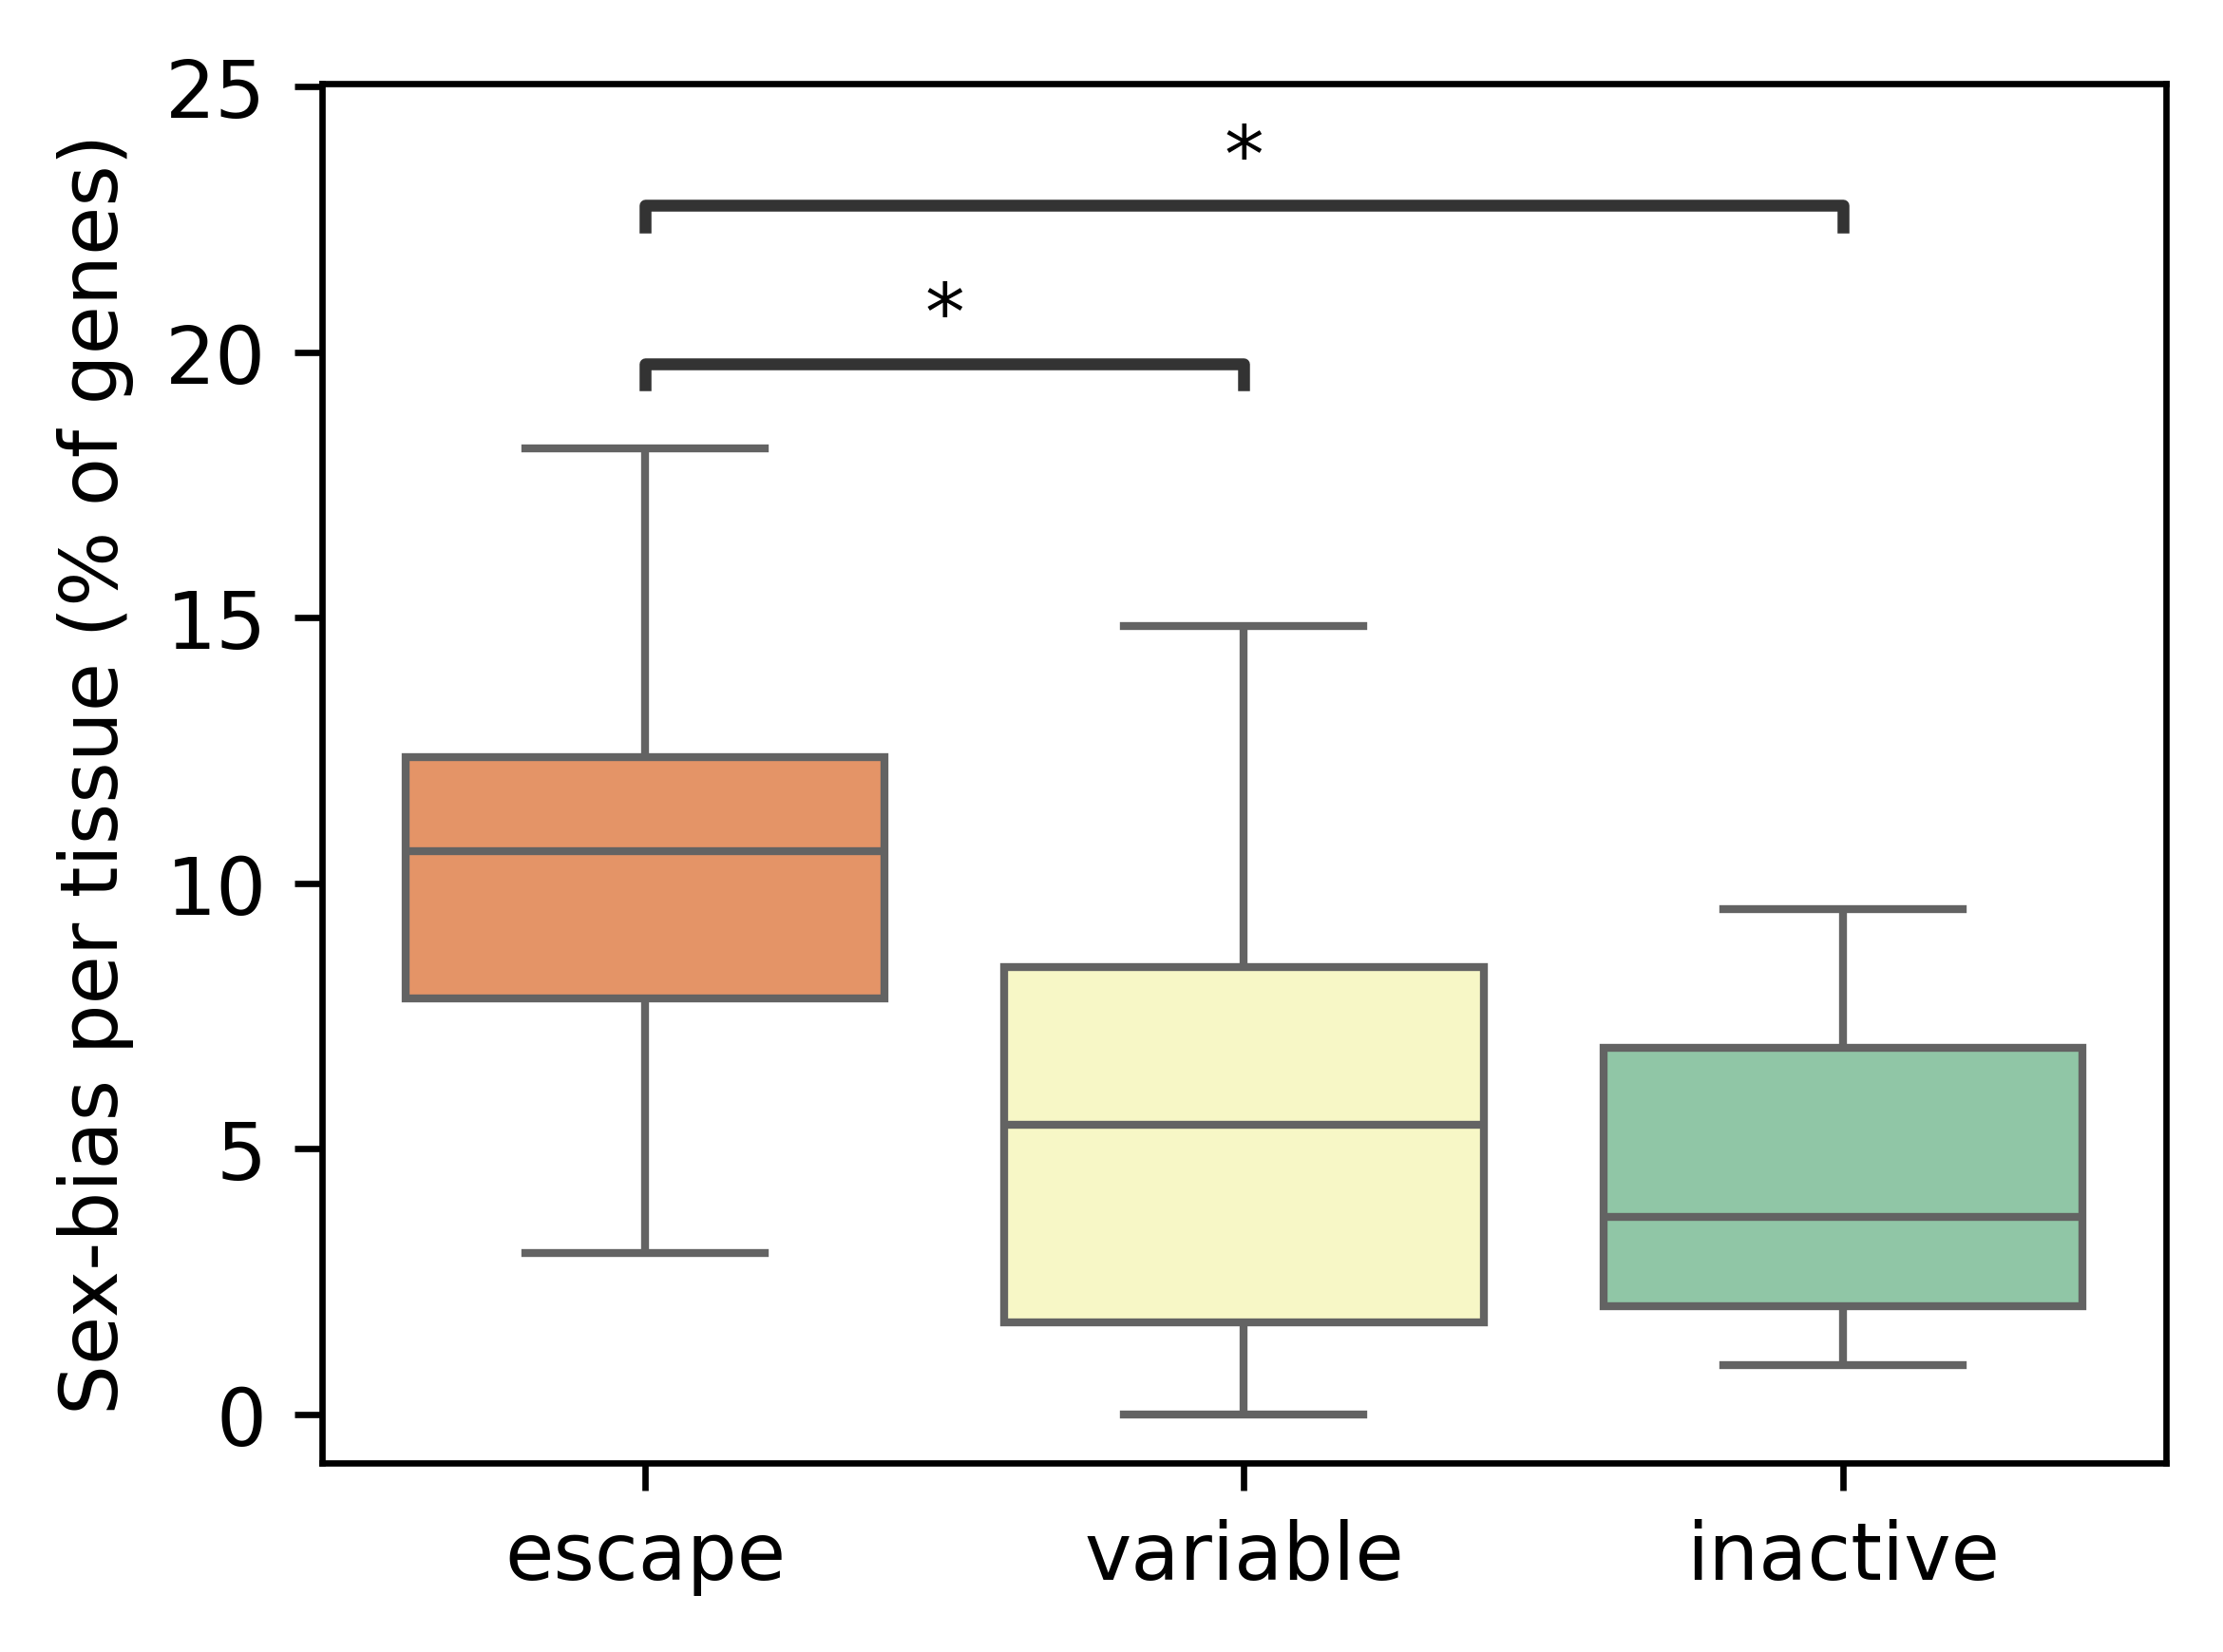

In [303]:
from statannotations.Annotator import Annotator

df_long = pd.melt(pd.DataFrame(num_dict), var_name='Category', value_name='Percentage')

plt.figure(figsize=(4,3),dpi=600)
g1=sns.boxplot(x='Category', y='Percentage', data=df_long, palette='Spectral',showfliers=False)

plt.ylabel('Sex-bias per tissue (% of genes)')
plt.xlabel('')

box_pairs = [
    ('escape','variable'),
    ('escape','inactive'),
            ]

annot = Annotator(g1, box_pairs, data=df_long, x='Category', y='Percentage',)
annot.configure(test='Mann-Whitney', verbose=2,text_format='star')
annot.apply_test(#equal_var=False,
                 alternative='greater'
                )
annot.annotate()


plt.tight_layout()
plt.savefig('R2-2.pdf',dpi=800,format='pdf')


## Q4:



In [309]:
def load_GTEx():
    tissue_map_GTEx = {
                    'Adipose_Subcutaneous':'ADPSBQ', 
                    'Adipose_Visceral_Omentum':'ADPVSC',
                    'Adrenal_Gland':'ADRNLG', 
                    'Artery_Aorta':'ARTAORT', 
                    'Artery_Coronary':'ARTCRN',
                    'Artery_Tibial':'ARTTBL', 
                    'Brain_Amygdala':'BRNAMY',
                    'Brain_Anterior_cingulate_cortex_BA24':'BRNACC',
                    'Brain_Caudate_basal_ganglia':'BRNCDT', 
                    'Brain_Cerebellar_Hemisphere':'BRNCHB',
                    'Brain_Cerebellum':'BRNCHA', 
                    'Brain_Cortex':'BRNCTXA', 
                    'Brain_Frontal_Cortex_BA9':'BRNCTXB',
                    'Brain_Hippocampus':'BRNHPP', 
                    'Brain_Hypothalamus':'CRNHPT',
                    'Brain_Nucleus_accumbens_basal_ganglia':'BRNNCC',
                    'Brain_Putamen_basal_ganglia':'BRNPTM', 
                    'Brain_Spinal_cord_cervical_c.1':'BRNSPC',
                    'Brain_Substantia_nigra':'BRNSNG', 
                    'Breast_Mammary_Tissue':'BREAST',
                    'Cells_Cultured_fibroblasts':'FIBRBLS', 
                    'Cells_EBV.transformed_lymphocytes':'LCL',
                    'Colon_Sigmoid':'CLNSGM', 
                    'Colon_Transverse':'CLNTRN',
                    'Esophagus_Gastroesophageal_Junction':'ESPGEJ', 
                    'Esophagus_Mucosa':'ESPMCS',
                    'Esophagus_Muscularis':'ESPMSL', 
                    'Heart_Atrial_Appendage':'HRTAA',
                    'Heart_Left_Ventricle':'HRTLV', 
                    'Kidney_Cortex':'KDNCTX', 
                    'Liver':'LIVER', 
                    'Lung':'LUNG',
                    'Minor_Salivary_Gland':'SLVRYG',
                    'Muscle_Skeletal':'MSCLSK', 
                    'Nerve_Tibial':'NERVET',
                    'Pancreas':'PNCREAS', 
                    'Pituitary':'PTTARY', 
                    'Skin_Not_Sun_Exposed_Suprapubic':'SKINNS',
                    'Skin_Sun_Exposed_Lower_leg':'SKINS', 
                    'Small_Intestine_Terminal_Ileum':'SNTTRM',
                    'Spleen':'SPLEEN', 
                    'Stomach':'STMACH', 
                    'Thyroid':'THYROID', 
                    'Whole_Blood':'WHLBLD'

                }

    gtex_de = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/TS_project/GTEx_Analysis_v8_sbgenes/signif.sbgenes.txt', sep='\t')

    # Load GTF data
    gtf = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/TS_project/gencode.v41.annotation.gtf', comment='#', sep='\t', header=None)
    gtf_columns = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
    gtf.columns = gtf_columns
    gtf['gene_id'] = gtf['attribute'].str.extract('gene_id "([^"]+)"')
    gtf['gene_name'] = gtf['attribute'].str.extract('gene_name "([^"]+)"')
    gtf['gene_type'] = gtf['attribute'].str.extract('gene_type "([^"]+)"')
    gtf['chr'] = gtf['seqname']

    # Create mappings
    gene_symbol_mapping = gtf[['gene_id', 'gene_name']].drop_duplicates()
    gene_chr_mapping = gtf[['gene_id', 'chr']].drop_duplicates()
    gene_type_mapping = gtf[['gene_id', 'gene_type']].drop_duplicates()

    id_to_symbol = {row['gene_id'].split('.')[0]: row['gene_name'] for index, row in gene_symbol_mapping.iterrows()}
    id_to_chr = {row['gene_id'].split('.')[0]: row['chr'] for index, row in gene_chr_mapping.iterrows()}
    id_to_type = {row['gene_id'].split('.')[0]: row['gene_type'] for index, row in gene_type_mapping.iterrows()}

    # Map gene IDs to symbols and chromosome numbers
    gtex_de['gene_symbol'] = gtex_de['gene'].map(lambda x: id_to_symbol.get(x.split('.')[0], x))
    gtex_de['chr'] = gtex_de['gene'].map(lambda x: id_to_chr.get(x.split('.')[0]))
    # Add coding_status
    gtex_de['coding_status'] = gtex_de['gene'].map(lambda x: 'coding' if id_to_type.get(x.split('.')[0]) == 'protein_coding' else 'non-coding')

    gtex_de['tissue_rename'] = gtex_de['tissue'].map(lambda x: tissue_map_GTEx.get(x, x))
    gtex_de.index = gtex_de['gene_symbol'].values

    mapping_dict = {'Fat':['ADPSBQ','ADPVSC'],
            'Spleen':['SPLEEN'],
            'Salivary_Gland':['SLVRYG'],
            'Lung':['LUNG'],
            'Blood':['WHLBLD'],
            'Skin':['SKINNS','SKINS'],
            'Small_Intestine':['SNTTRM'],
            'Muscle':['MSCLSK'],
            'Vasculature':['ARTTBL','ARTAORT','ARTCRN'],
            'Heart':['HRTAA','HRTLV'],
            'Large_Intestine':['CLNSGM','CLNTRN']
    }
    items_list = [item for sublist in mapping_dict.values() for item in sublist]

    gtex_de = gtex_de[gtex_de['tissue_rename'].isin(items_list)] 
    
    # Load effect size data
    effect_size_all = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/TS_project/GTEx_Analysis_v8_sbgenes/effect_size.tsv', sep='\t')
    effect_size_all.index = effect_size_all.index.map(lambda x: x.split('.')[0])
    effect_size_all['gene_symbol'] = effect_size_all.index.map(lambda x: id_to_symbol.get(x, x))
    effect_size_all['chr'] = effect_size_all.index.map(lambda x: id_to_chr.get(x))
    # Add coding_status
    effect_size_all['coding_status'] = effect_size_all.index.map(lambda x: 'coding' if id_to_type.get(x) == 'protein_coding' else 'non-coding')
    effect_size_all.index = effect_size_all['gene_symbol'].values

    return gtex_de,effect_size_all

In [310]:
GTEx_data_df, GTEx_data_raw = load_GTEx()

In [313]:
GTEx_data_df

gene                tissue   effsize  effsize_se  \
XIST    ENSG00000229807.10  Adipose_Subcutaneous  9.802124    0.071315   
KDM6A   ENSG00000147050.14  Adipose_Subcutaneous  0.623656    0.012053   
KDM5C   ENSG00000126012.11  Adipose_Subcutaneous  0.455892    0.010462   
GREB1L  ENSG00000141449.14  Adipose_Subcutaneous -1.378039    0.092807   
ZBED1   ENSG00000214717.11  Adipose_Subcutaneous -0.277546    0.016683   
...                    ...                   ...       ...         ...   
OSTM1   ENSG00000081087.14           Whole_Blood -0.026424    0.013430   
MZF1     ENSG00000099326.8           Whole_Blood -0.031894    0.016264   
GNL3L   ENSG00000130119.15           Whole_Blood -0.036301    0.018482   
MPP1    ENSG00000130830.14           Whole_Blood  0.040347    0.019689   
BAG6    ENSG00000204463.12           Whole_Blood -0.038754    0.018321   

            lfsr gene_symbol    chr coding_status tissue_rename  
XIST    0.000000        XIST   chrX    non-coding        ADPSBQ  
KDM6A   0.000000       KDM6A   chrX        coding        ADPSBQ  
KDM5C   0.000000       KDM5C   chrX        coding        ADPSBQ  
GREB1L  0.000000      GREB1L  chr18        coding        ADPSBQ  
ZBED1   0.000000       ZBED1   chrY        coding        ADPSBQ  
...          ...         ...    ...           ...           ...  
OSTM1   0.030716       OSTM1   chr6        coding        WHLBLD  
MZF1    0.041241        MZF1  chr19        coding        WHLBLD  
GNL3L   0.044238       GNL3L   chrX        coding        WHLBLD  
MPP1    0.046199        MPP1   chrX        coding        WHLBLD  
BAG6    0.048910        BAG6   chr6        coding        WHLBLD  

[49059 rows x 9 columns]

In [317]:
import pandas as pd

data = {
    'gene_symbol': GTEx_data_df.index,
    'effsize': GTEx_data_df.effsize,
    'effsize_se': GTEx_data_df.effsize_se
}

df_gtex = pd.DataFrame(data)
df_gtex['variance'] = df_gtex['effsize_se'] ** 2
df_gtex


gene_symbol   effsize  effsize_se  variance
XIST          XIST  9.802124    0.071315  0.005086
KDM6A        KDM6A  0.623656    0.012053  0.000145
KDM5C        KDM5C  0.455892    0.010462  0.000109
GREB1L      GREB1L -1.378039    0.092807  0.008613
ZBED1        ZBED1 -0.277546    0.016683  0.000278
...            ...       ...         ...       ...
OSTM1        OSTM1 -0.026424    0.013430  0.000180
MZF1          MZF1 -0.031894    0.016264  0.000265
GNL3L        GNL3L -0.036301    0.018482  0.000342
MPP1          MPP1  0.040347    0.019689  0.000388
BAG6          BAG6 -0.038754    0.018321  0.000336

[49059 rows x 4 columns]

In [47]:

def simulate_bulk_counts(mean_expr, effsize, dispersion, n_samples=10):
    p1 = dispersion / (dispersion + mean_expr)
    group1 = stats.nbinom.rvs(dispersion, p1, size=n_samples)

    group2_mean = mean_expr * (2**effsize)
    p2 = dispersion / (dispersion + group2_mean)
    group2 = stats.nbinom.rvs(dispersion, p2, size=n_samples)
    
    return group1, group2

# same logic for single-cell simulation but with dropout:
def simulate_singlecell_counts(mean_expr, effsize, dispersion, dropout_rate=0.8, n_cells=500):
    p1 = dispersion / (dispersion + mean_expr)
    group1 = stats.nbinom.rvs(dispersion, p1, size=n_cells)

    group2_mean = mean_expr * (2**effsize)
    p2 = dispersion / (dispersion + group2_mean)
    group2 = stats.nbinom.rvs(dispersion, p2, size=n_cells)

    dropout1 = np.random.binomial(1, dropout_rate, n_cells)
    dropout2 = np.random.binomial(1, dropout_rate, n_cells)
    group1[dropout1 == 1] = 0
    group2[dropout2 == 1] = 0
    
    return group1, group2

from scipy.stats import mannwhitneyu

def power_analysis(mean_expr, effsize, dispersion, 
                   simulate_func, 
                   dropout_rate=None,
                   n_simulations=500, 
                   alpha=0.05):
    significant_results = 0
    
    for _ in range(n_simulations):
        if dropout_rate is not None:
            group1, group2 = simulate_func(mean_expr, effsize, dispersion, dropout_rate=dropout_rate)
        else:
            group1, group2 = simulate_func(mean_expr, effsize, dispersion)
        
        # Using Mann-Whitney U test (Wilcoxon rank-sum test)
        _, pvalue = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        
        if pvalue < alpha:
            significant_results += 1
    
    power = significant_results / n_simulations
    return power



Effsize: 0.10, Dispersion: 0.10, Bulk power: 0.01, scRNA power: 0.06
Effsize: 0.64, Dispersion: 0.10, Bulk power: 0.06, scRNA power: 0.06
Effsize: 1.19, Dispersion: 0.10, Bulk power: 0.05, scRNA power: 0.08
Effsize: 1.73, Dispersion: 0.10, Bulk power: 0.08, scRNA power: 0.25
Effsize: 2.28, Dispersion: 0.10, Bulk power: 0.07, scRNA power: 0.25
Effsize: 2.82, Dispersion: 0.10, Bulk power: 0.09, scRNA power: 0.48
Effsize: 3.37, Dispersion: 0.10, Bulk power: 0.05, scRNA power: 0.58
Effsize: 3.91, Dispersion: 0.10, Bulk power: 0.17, scRNA power: 0.68
Effsize: 4.46, Dispersion: 0.10, Bulk power: 0.25, scRNA power: 0.74
Effsize: 5.00, Dispersion: 0.10, Bulk power: 0.20, scRNA power: 0.82
Effsize: 0.10, Dispersion: 0.64, Bulk power: 0.04, scRNA power: 0.09
Effsize: 0.64, Dispersion: 0.64, Bulk power: 0.07, scRNA power: 0.13
Effsize: 1.19, Dispersion: 0.64, Bulk power: 0.14, scRNA power: 0.29
Effsize: 1.73, Dispersion: 0.64, Bulk power: 0.30, scRNA power: 0.58
Effsize: 2.28, Dispersion: 0.64, B

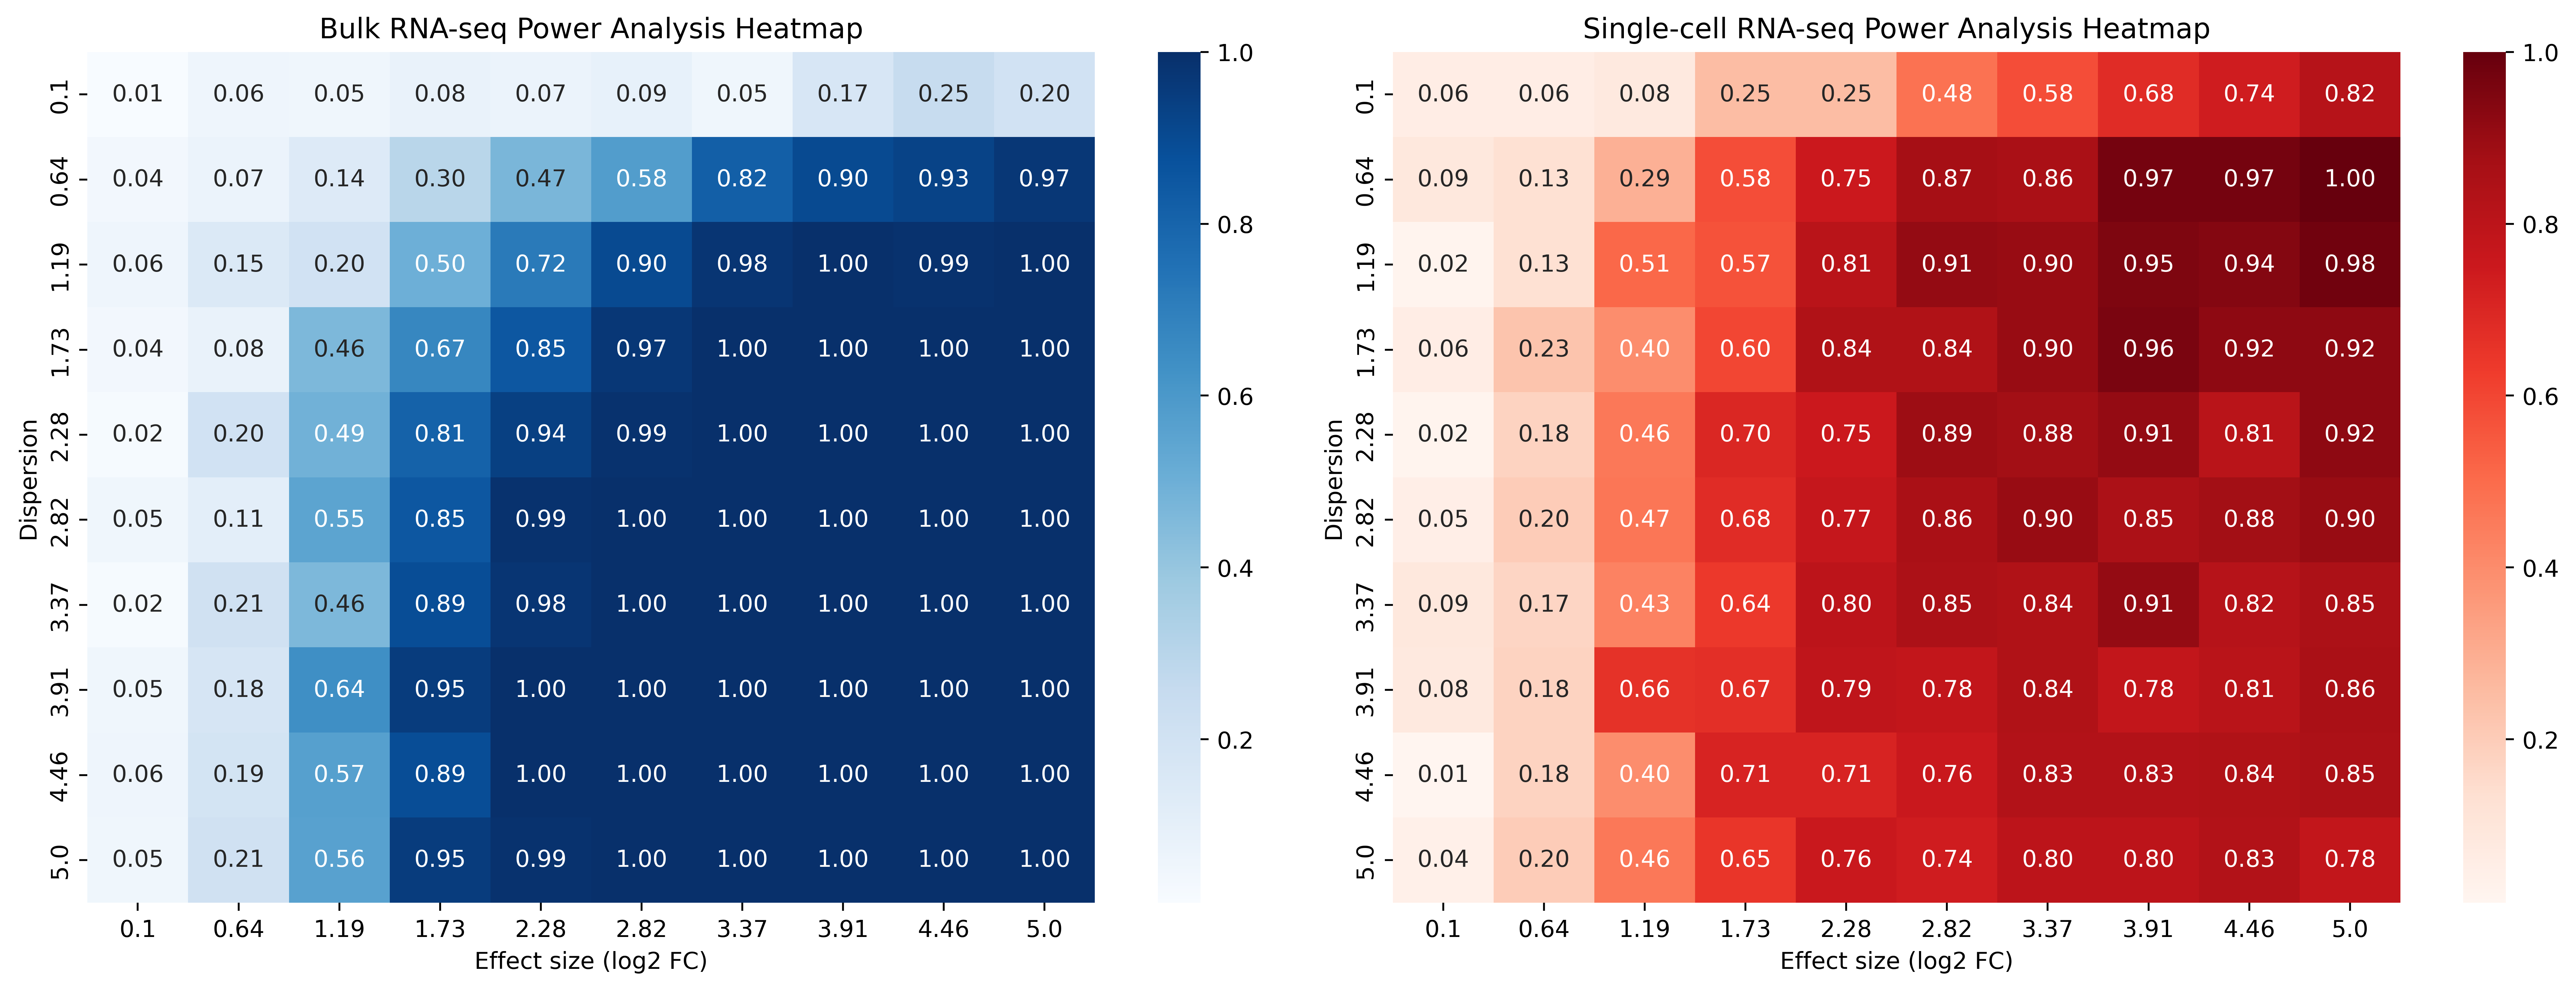

In [403]:
mean_expr = 2
dropout_rate=0.8

# Define a range of effect sizes and dispersions to explore
effsize_range = np.linspace(0.1, 5, 10)  # effect sizes from small (0.1) to large (1.5)
dispersion_range = np.linspace(0.1, 5, 10)  # dispersion from low (1) to high (20)

# DataFrame to store power results
bulk_power_matrix = np.zeros((len(dispersion_range), len(effsize_range)))
sc_power_matrix = np.zeros((len(dispersion_range), len(effsize_range)))

# Run simulations across parameter grid
for i, dispersion in enumerate(dispersion_range):
    for j, effsize in enumerate(effsize_range):
        bulk_power = power_analysis(mean_expr, effsize, dispersion, 
                                    simulate_bulk_counts, dropout_rate=None, n_simulations=100)
        sc_power = power_analysis(mean_expr, effsize, dispersion, 
                                  simulate_singlecell_counts, dropout_rate=dropout_rate, n_simulations=100)
        bulk_power_matrix[i, j] = bulk_power
        sc_power_matrix[i, j] = sc_power
        print(f"Effsize: {effsize:.2f}, Dispersion: {dispersion:.2f}, Bulk power: {bulk_power:.2f}, scRNA power: {sc_power:.2f}")

# Convert matrices to DataFrames for visualization
bulk_df = pd.DataFrame(bulk_power_matrix, index=np.round(dispersion_range, 2), columns=np.round(effsize_range, 2))
sc_df = pd.DataFrame(sc_power_matrix, index=np.round(dispersion_range, 2), columns=np.round(effsize_range, 2))



In [ ]:
# Plotting heatmaps
plt.figure(figsize=(12,5),dpi=500)

# Bulk RNA-seq power heatmap
plt.subplot(1, 2, 1)
sns.heatmap(bulk_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("Bulk RNA-seq Power Analysis Heatmap")
plt.ylabel("Dispersion")
plt.xlabel("Effect size (log2 FC)")

# Single-cell RNA-seq power heatmap
plt.subplot(1, 2, 2)
sns.heatmap(sc_df, annot=True, fmt=".2f", cmap="Reds")
plt.title("Single-cell RNA-seq Power Analysis Heatmap")
plt.ylabel("Dispersion")
plt.xlabel("Effect size (log2 FC)")

plt.tight_layout()
plt.show()

## Q5:


In [45]:
def power_analysis(mean_expr, effsize, dispersion, simulate_func, 
                   dropout_rate=None, n_samples=10, n_simulations=300, alpha=0.05):
    significant_results = 0
    for _ in range(n_simulations):
        if dropout_rate is not None:
            group1, group2 = simulate_func(mean_expr, effsize, dispersion, dropout_rate=dropout_rate, n_cells=n_samples)
        else:
            group1, group2 = simulate_func(mean_expr, effsize, dispersion, n_samples=n_samples)
        _, pvalue = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        if pvalue < alpha:
            significant_results += 1
    return significant_results / n_simulations

In [ ]:
mean_expr = 2
effsize = 0.5          # fixed moderate effect size (log2 FC)
dispersion = 5         # fixed dispersion (variance level)
dropout_rate = 0.8     # single-cell dropout rate

# Vary sample size:
bulk_sample_sizes = np.linspace(5, 200, 10).astype(int)         # from 5 to 50 bulk samples
sc_sample_sizes = np.linspace(1000, 12000, 10).astype(int)        # from 100 to 1000 single cells

bulk_power_results = []
sc_power_results = []

# Run simulations for bulk RNA-seq varying sample size
for n_samples in bulk_sample_sizes:
    power = power_analysis(mean_expr, effsize, dispersion, 
                           simulate_bulk_counts, dropout_rate=None, 
                           n_samples=n_samples, n_simulations=200)
    bulk_power_results.append(power)
    print(f"Bulk samples: {n_samples}, Power: {power:.2f}")

# Run simulations for single-cell RNA-seq varying number of cells
for n_cells in sc_sample_sizes:
    power = power_analysis(mean_expr, effsize, dispersion, 
                           simulate_singlecell_counts, dropout_rate=dropout_rate, 
                           n_samples=n_cells, n_simulations=200)
    sc_power_results.append(power)
    print(f"Single-cell samples (cells): {n_cells}, Power: {power:.2f}")



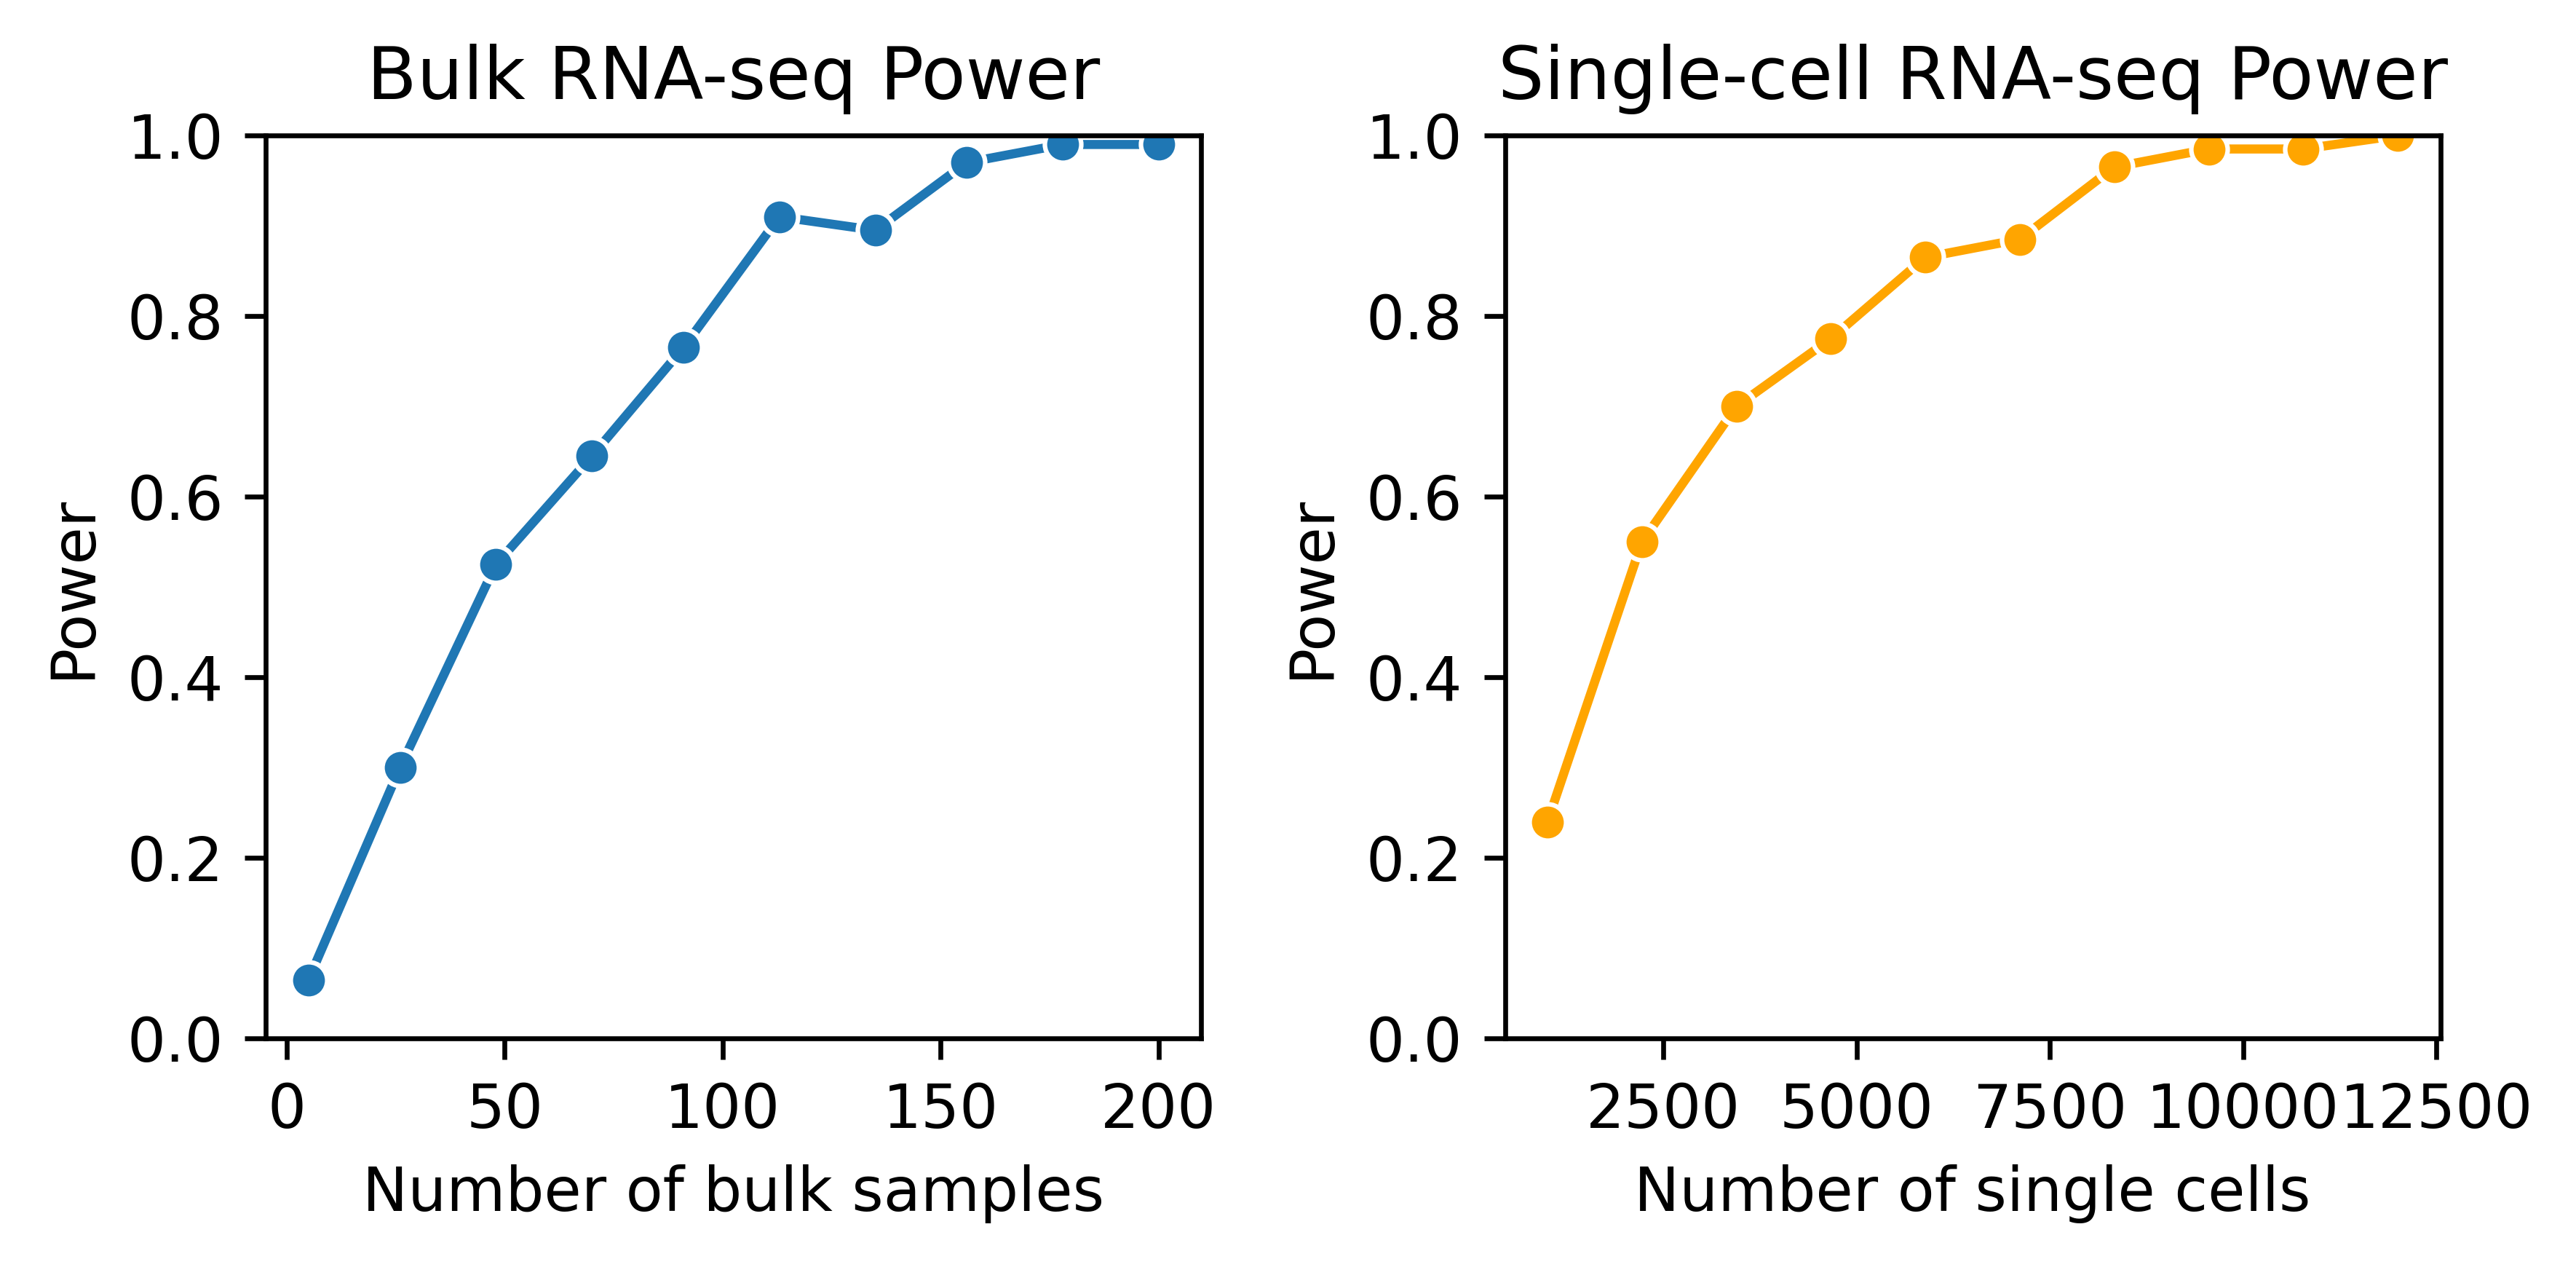

In [72]:
# Plot clearly:
plt.figure(figsize=(6,3),dpi=600)

# Bulk RNA-seq
plt.subplot(1, 2, 1)
sns.lineplot(x=bulk_sample_sizes, y=bulk_power_results, marker='o')
plt.title('Bulk RNA-seq Power')
plt.xlabel('Number of bulk samples')
plt.ylabel('Power')
plt.ylim(0, 1)

# Single-cell RNA-seq
plt.subplot(1, 2, 2)
sns.lineplot(x=sc_sample_sizes, y=sc_power_results, marker='o', color='orange')
plt.title('Single-cell RNA-seq Power')
plt.xlabel('Number of single cells')
plt.ylabel('Power')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('R11-1.pdf',dpi=800,format='pdf')


In [ ]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Realistic pseudobulk simulation (including biological variability)
def simulate_pseudobulk_counts(mean_expr, effsize, dispersion, dropout_rate,
                               n_cells_per_pseudobulk, n_pseudobulk_samples,
                               bio_sd=0.2):
    # simulate biological variation across pseudobulk samples clearly:
    bio_means_group1 = np.random.lognormal(mean=np.log(mean_expr), sigma=bio_sd, size=n_pseudobulk_samples)
    bio_means_group2 = bio_means_group1 * (2 ** effsize)  # applying fold-change clearly

    pseudobulk_group1 = []
    pseudobulk_group2 = []

    for mean1, mean2 in zip(bio_means_group1, bio_means_group2):
        # Group 1 single cells
        p1 = dispersion / (dispersion + mean1)
        cells_grp1 = stats.nbinom.rvs(dispersion, p1, size=n_cells_per_pseudobulk)
        cells_grp1[np.random.binomial(1, dropout_rate, n_cells_per_pseudobulk) == 1] = 0
        pseudobulk_group1.append(cells_grp1.sum())

        # Group 2 single cells
        p2 = dispersion / (dispersion + mean2)
        cells_grp2 = stats.nbinom.rvs(dispersion, p2, size=n_cells_per_pseudobulk)
        cells_grp2[np.random.binomial(1, dropout_rate, n_cells_per_pseudobulk) == 1] = 0
        pseudobulk_group2.append(cells_grp2.sum())

    return np.array(pseudobulk_group1), np.array(pseudobulk_group2)

# Power analysis function clearly explained:
def pseudobulk_power_analysis(mean_expr, effsize, dispersion, dropout_rate,
                              n_cells_per_pseudobulk, n_pseudobulk_samples,
                              bio_sd=0.2, n_simulations=200, alpha=0.05):
    significant_results = 0
    for _ in range(n_simulations):
        grp1, grp2 = simulate_pseudobulk_counts(mean_expr, effsize, dispersion,
                                                dropout_rate, n_cells_per_pseudobulk,
                                                n_pseudobulk_samples, bio_sd)
        _, pvalue = stats.mannwhitneyu(grp1, grp2, alternative='two-sided')
        if pvalue < alpha:
            significant_results += 1
    return significant_results / n_simulations

# Realistic parameters
mean_expr = 2
effsize = 0.5            # log2 fold-change
dispersion = 5           # moderate dispersion
dropout_rate = 0.8       # realistic dropout
n_cells_per_pseudobulk = 5000  # large, realistic single-cell aggregation
bio_sd = 0.5             # biological variability (realistic)

# Clearly vary pseudobulk samples (replicates)
pseudobulk_samples_range = np.arange(1, 50, 5)
powers = []

for n_pseudobulk_samples in pseudobulk_samples_range:
    power = pseudobulk_power_analysis(mean_expr, effsize, dispersion, dropout_rate,
                                      n_cells_per_pseudobulk, n_pseudobulk_samples,
                                      bio_sd, n_simulations=200)
    powers.append(power)
    print(f"Pseudobulk samples: {n_pseudobulk_samples}, Power: {power:.2f}")

 

Pseudobulk samples: 1, Power: 0.00
Pseudobulk samples: 6, Power: 0.09
Pseudobulk samples: 16, Power: 0.51
Pseudobulk samples: 21, Power: 0.79
Pseudobulk samples: 26, Power: 0.94
Pseudobulk samples: 31, Power: 0.99


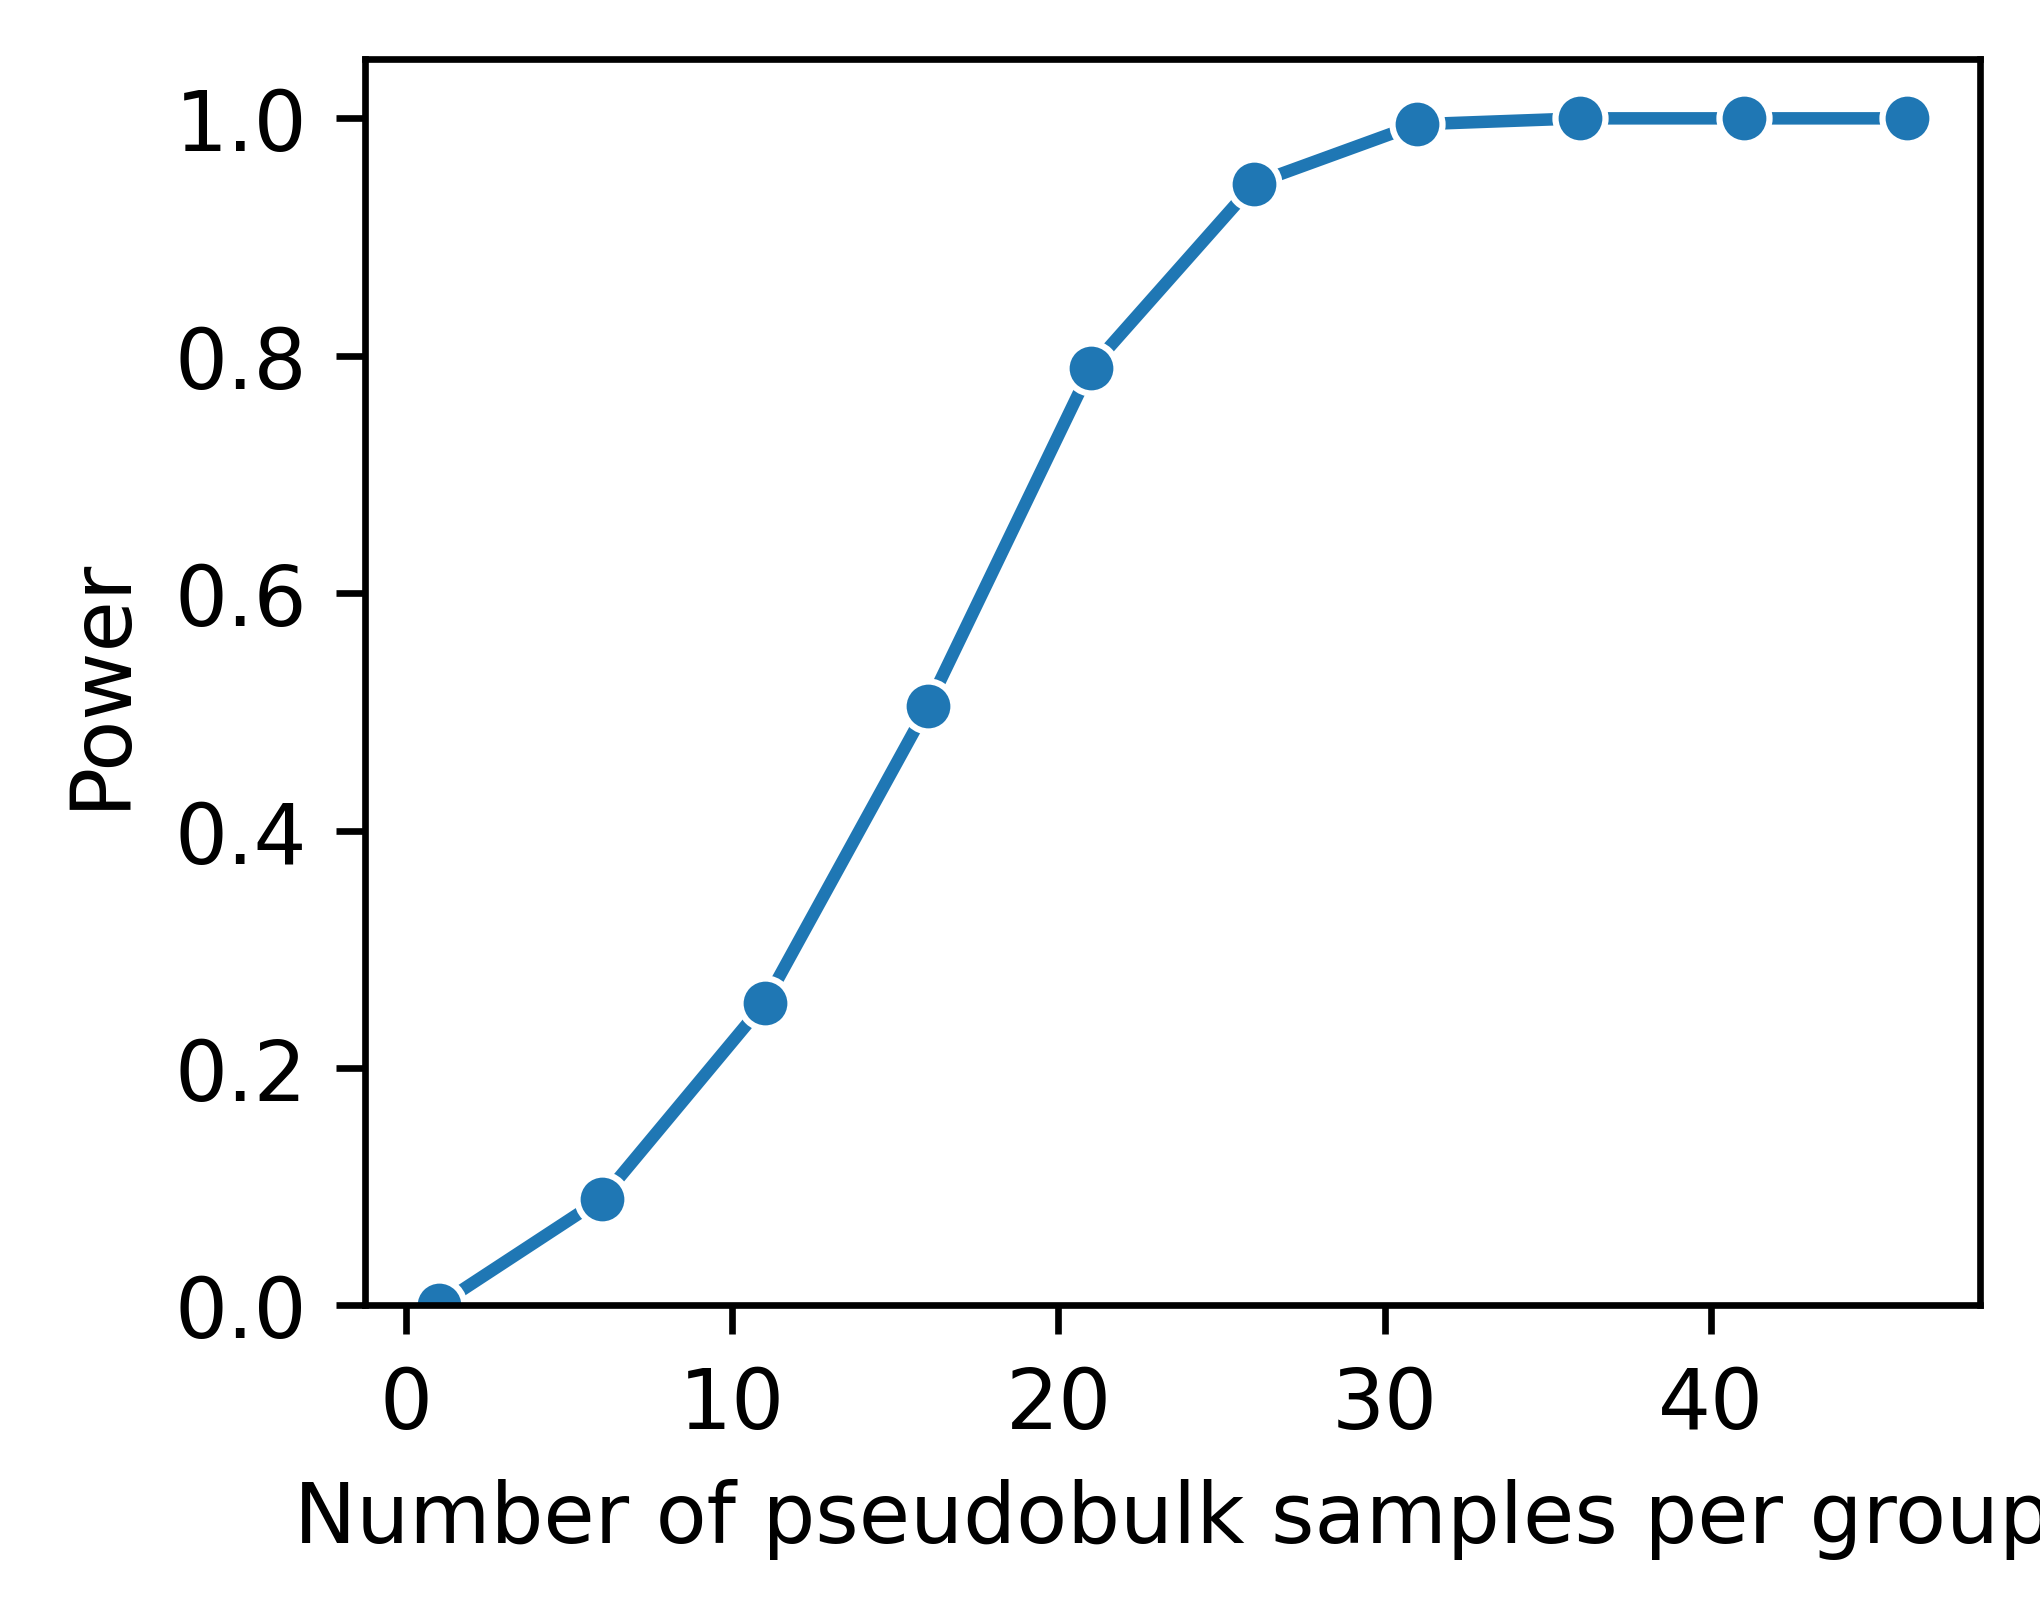

In [50]:
# Plot results clearly:
plt.figure(figsize=(3.5,2.8),dpi=600)
sns.lineplot(x=pseudobulk_samples_range, y=powers, marker='o')
#plt.title('Realistic Pseudobulk Power vs. Number of Pseudobulk Samples\n(with biological variability)')
plt.xlabel('Number of pseudobulk samples per group')
plt.ylabel('Power')
plt.ylim(0, 1.05)
plt.grid(False)
plt.tight_layout()
plt.savefig('R11-2.pdf',dpi=800,format='pdf')


- Correlation analysis in GTEX to identify gene groups that are co-expressed with X-linked genes, identify clusters of cells that score higher for these gene groups

In [75]:
!wget https://storage.googleapis.com/adult-gtex/bulk-gex/v8/rna-seq/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz



98877.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


--2025-08-15 14:50:54--  https://storage.googleapis.com/adult-gtex/bulk-gex/v8/rna-seq/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.72.155, 142.250.72.187, 142.250.176.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.72.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 917091994 (875M) [application/octet-stream]
Saving to: ‘GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz’

GTEx_Analysis_2017- 100%[===================>] 874.61M  68.7MB/s    in 14s     

2025-08-15 14:51:08 (64.6 MB/s) - ‘GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz’ saved [917091994/917091994]



In [77]:
!gunzip GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz

105099.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [58]:
import pandas as pd

gtex_path = 'GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct'
# GCT file has metadata in the first 2 rows
gtex_df = pd.read_csv(gtex_path, sep='\t', skiprows=2)

# Set gene names as index
gtex_df = gtex_df.rename(columns={"Name": "gene_symbol"})
gtex_df = gtex_df.set_index("gene_symbol")

# Remove non-numeric columns (e.g., "Description")
gtex_expr = gtex_df.drop(columns=["Description"])


In [59]:
import mygene
mg = mygene.MyGeneInfo()
ensembl_ids = [g.split('.')[0] for g in gtex_expr.index]

query_result = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')

mapping_df = pd.DataFrame(query_result)
mapping_df = mapping_df[['query', 'symbol']].dropna().drop_duplicates()

gtex_expr = gtex_expr.copy()
gtex_expr['ensembl_clean'] = gtex_expr.index.str.split('.').str[0]
gtex_expr = gtex_expr.merge(mapping_df, left_on='ensembl_clean', right_on='query')
gtex_expr = gtex_expr.set_index('symbol')

65 input query terms found dup hits:	[('ENSG00000228044', 2), ('ENSG00000226506', 2), ('ENSG00000261600', 2), ('ENSG00000234162', 2), ('E
1521 input query terms found no hit:	['ENSG00000238009', 'ENSG00000236743', 'ENSG00000278566', 'ENSG00000273547', 'ENSG00000283574', 'ENS


In [60]:
x_linked_genes = edgeR_LRT_all[edgeR_LRT_all.chr_new=='chrX'].index.unique()
x_linked_genes = list(set(x_linked_genes).intersection(gtex_expr.index))


In [61]:
#Compute correlation of all genes with X-linked genes

# Transpose for correlation: rows = samples, columns = genes
gtex_expr_T = gtex_expr.T

gtex_expr_T = gtex_expr_T.iloc[:-2,:]

# Correlation of each gene with each X-linked gene
corr_matrix = gtex_expr_T.corrwith(gtex_expr_T[x_linked_genes].mean(axis=1), axis=0)

# Drop NaNs
corr_matrix = corr_matrix.dropna()

# Select top co-expressed genes
top_corr_genes = corr_matrix.sort_values(ascending=False).head(300).index.tolist()


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide


In [62]:
import pandas as pd

# Load GTF
gtf = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/TS_project/gencode.v41.annotation.gtf', 
                  comment='#', sep='\t', header=None)

# Assign column names
gtf.columns = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']

# Extract gene name and type from attributes
gtf['gene_name'] = gtf['attribute'].str.extract('gene_name "([^"]+)"')
gtf['gene_type'] = gtf['attribute'].str.extract('gene_type "([^"]+)"')
gtf['chr'] = gtf['seqname']

# Build lookup table
gene_info_mapping = gtf[['gene_name', 'chr', 'gene_type']].drop_duplicates().set_index('gene_name')


In [63]:
# Define autosomes
autosomes = ['chr'+str(i) for i in range(1, 23)]

# Get chromosome for top_corr_genes
gene_chr_lookup = gene_info_mapping.loc[
    gene_info_mapping.index.intersection(top_corr_genes)
]

# Keep only autosomal
autosomal_top_corr_genes = gene_chr_lookup[gene_chr_lookup['chr'].isin(autosomes)].index.tolist()

print(f"Top correlated genes: {len(top_corr_genes)}")
print(f"Autosomal top correlated genes: {len(autosomal_top_corr_genes)}")


Top correlated genes: 300
Autosomal top correlated genes: 275


In [64]:
len(autosomal_top_corr_genes)

275

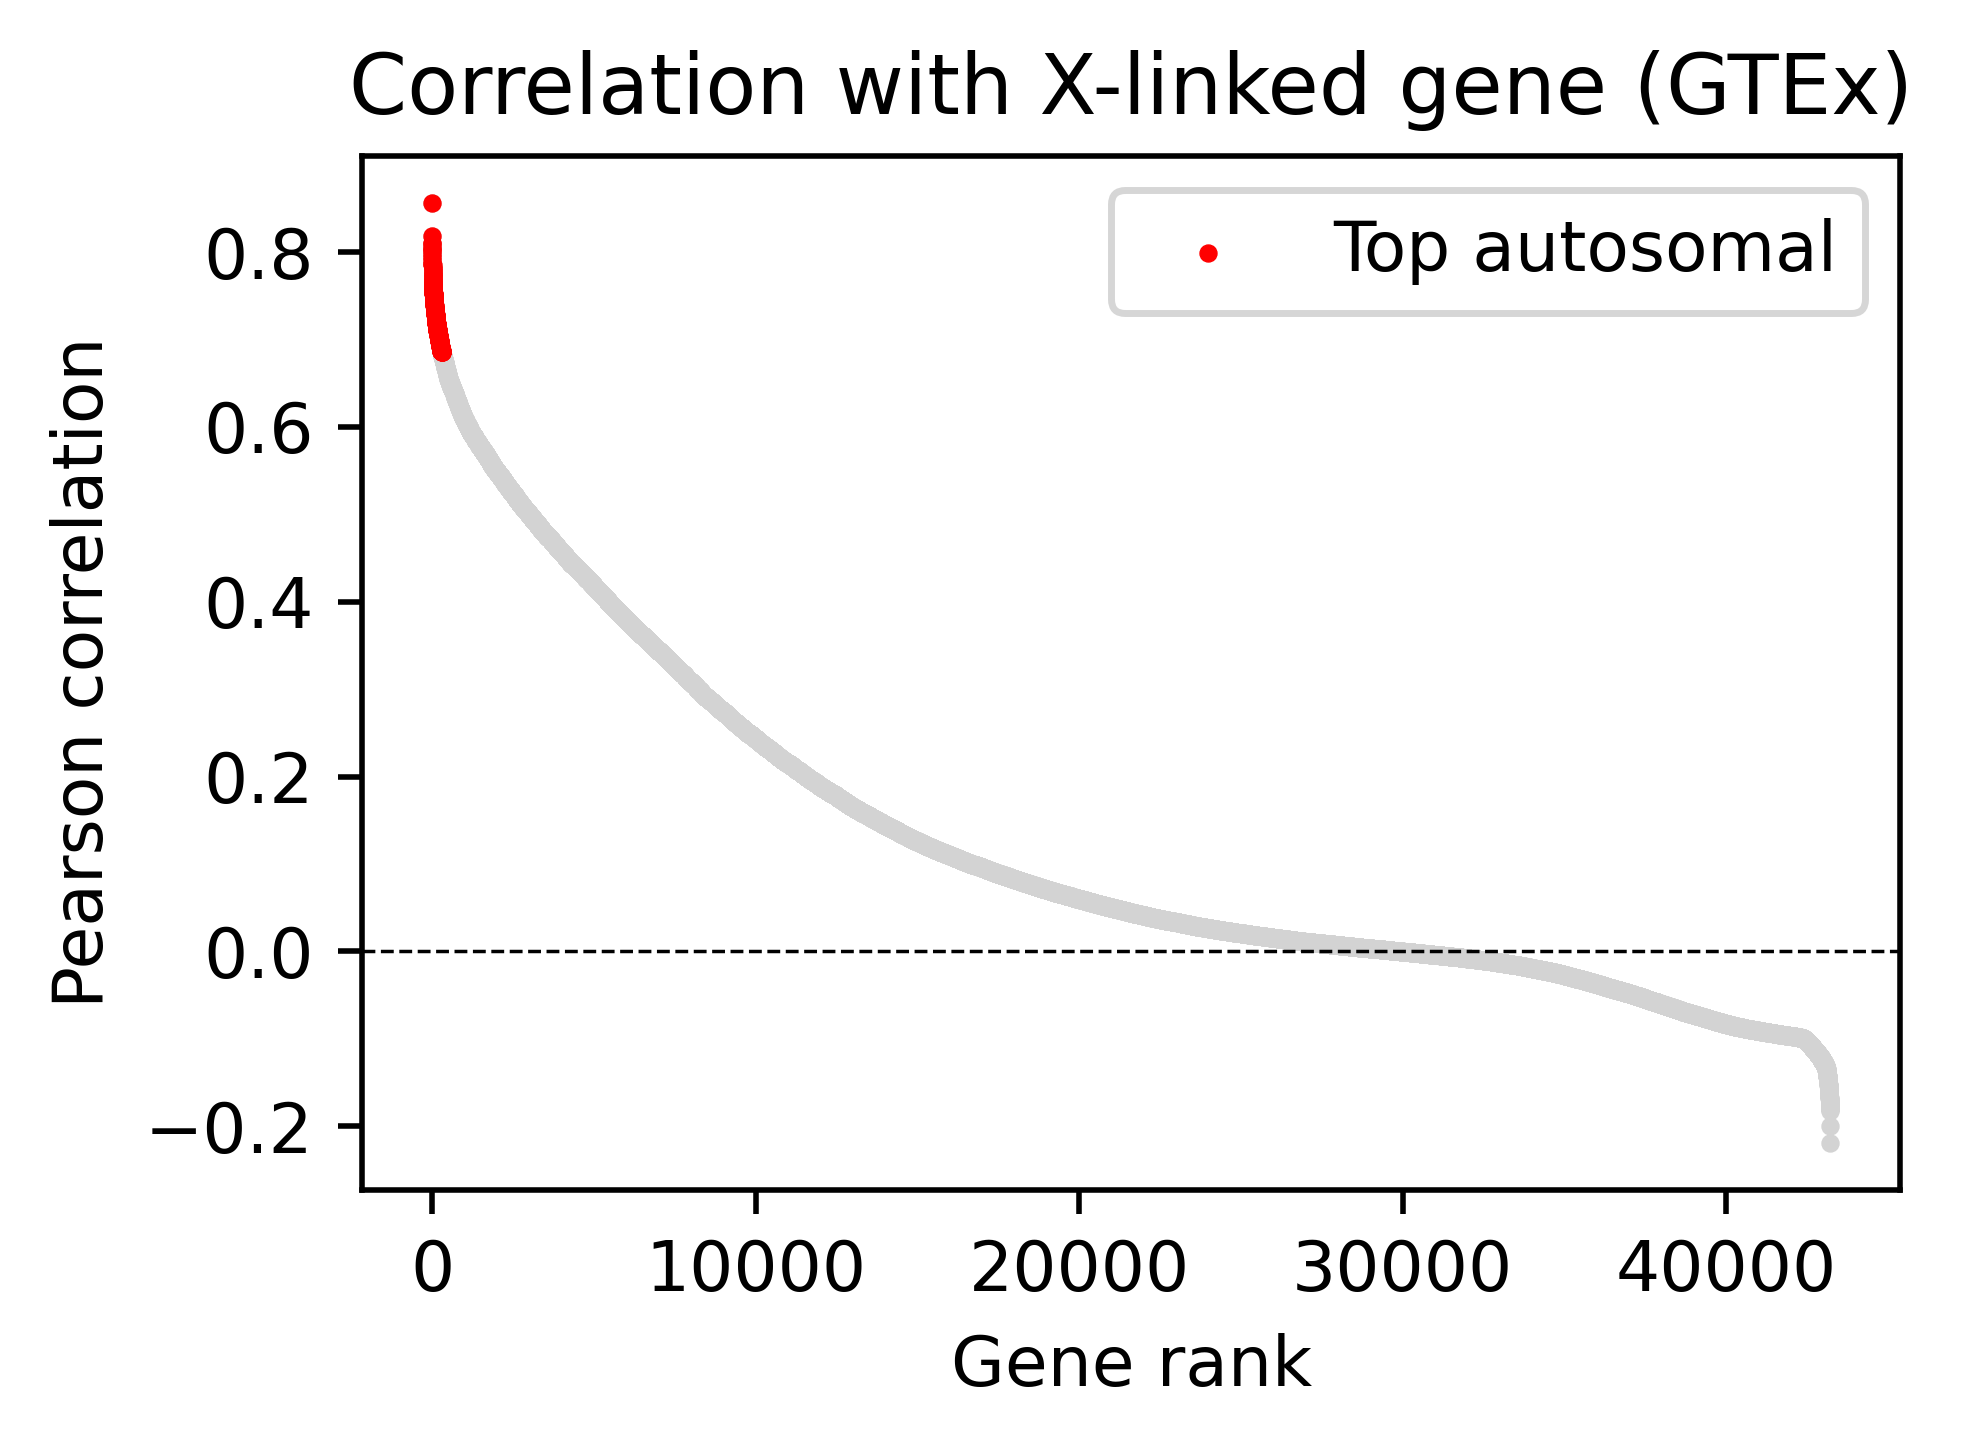

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert correlation matrix to DataFrame
corr_df = corr_matrix.sort_values(ascending=False).reset_index()
corr_df.columns = ['gene', 'correlation']

# Add highlight column for autosomal top correlated genes
corr_df['highlight'] = corr_df['gene'].isin(autosomal_top_corr_genes)

# Plot
plt.figure(figsize=(4, 3), dpi=500)

sns.scatterplot(
    data=corr_df,
    x=range(len(corr_df)),
    y='correlation',
    color='lightgray',
    edgecolor=None,
    s=6,
    label=None
)

# Overlay top autosomal genes (red)
highlight_df = corr_df[corr_df['highlight']]
sns.scatterplot(
    data=highlight_df,
    x=highlight_df.index,
    y='correlation',
    color='red',
    s=6,
    edgecolor=None,
    label='Top autosomal'
)

plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.title("Correlation with X-linked gene (GTEx)")
plt.xlabel("Gene rank")
plt.ylabel("Pearson correlation")
plt.tight_layout()
plt.savefig('R11-3.pdf', dpi=800, format='pdf')


In [164]:
np.save('top_corr_genes_GTEx.npy',top_corr_genes)


In [66]:
# cell & tissue
folder_path= '/hpc/projects/tabula_sapiens/singlecell_transcriptomics/TSP1_30_Paper2_Version2d_Oct2024/tissues/'
file_path_list_ = os.listdir(folder_path)
file_path_list = []
score_results = []
all_chrX_exp = pd.DataFrame()
genes_list = TS_data_df['gene_symbol'].unique() 
for tissue_ in sorted(TS_data_df['tissue'].unique()):
    for j in file_path_list_:
        if j.startswith(tissue_):
            adata_tissue_path = folder_path+j
            adata_tissue = sc.read_h5ad(adata_tissue_path)
            adata_tissue = adata_tissue[adata_tissue.obs['method']!='smartseq'].copy()
            for type_ in sorted(TS_data_df['cell_type'].unique()):
                temp_path = '/hpc/mydata/siyu.he/Siyu_projects/TS_project/pseudobulk_input/'+tissue_.replace(' ', '_')+'_'+type_.replace(' ', '_')+'.h5ad'
                if os.path.exists(temp_path):
                    print(tissue_+' '+type_)
                    #tmp = (TS_data_df['tissue']==tissue_)&(TS_data_df['type']==type_)
                    refer_adata = sc.read_h5ad(temp_path)
                    adata_tissue_ct = adata_tissue[adata_tissue.obs['broad_cell_class']==type_].copy()
                    adata_tissue_ct = adata_tissue_ct[refer_adata.obs_names,:]
                    #adata_tissue_ct = adata_tissue_ct[:,genes_list].copy()
                    if ((adata_tissue_ct.obs['sex']=='male').sum()>0)&((adata_tissue_ct.obs['sex']=='female').sum()>0):
                        adata_tissue_ct_male = adata_tissue_ct[adata_tissue_ct.obs['sex']=='male']
                        adata_tissue_ct_female = adata_tissue_ct[adata_tissue_ct.obs['sex']=='female']

                        sc.tl.score_genes(adata_tissue_ct_male, gene_list=top_corr_genes, score_name=f"GTEx_Xcorr_score_male")
                        sc.tl.score_genes(adata_tissue_ct_female, gene_list=top_corr_genes, score_name=f"GTEx_Xcorr_score_female")
 
                        mean_score_female = adata_tissue_ct_female.obs[f"GTEx_Xcorr_score_female"].mean()
                        mean_score_male = adata_tissue_ct_male.obs[f"GTEx_Xcorr_score_male"].mean()
                        score_results.append({
                            'tissue': tissue_,
                            'cell_type': type_,
                            'sex': 'female',
                            'mean_GTEx_Xcorr_score': mean_score_female
                        })
                        score_results.append({
                            'tissue': tissue_,
                            'cell_type': type_,
                            'sex': 'male',
                            'mean_GTEx_Xcorr_score': mean_score_male
                        })

Bladder contractile cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Bladder endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bladder fibroblast


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Bladder granulocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bladder myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Bladder t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Bladder transitional epithelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Blood erythroid lineage cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Blood granulocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Blood hematopoietic cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:1

Blood innate lymphoid cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Blood lymphocyte of b lineage


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Blood myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Blood t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Bone_Marrow granulocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bone_Marrow hematopoietic cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Bone_Marrow innate lymphoid cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Bone_Marrow lymphocyte of b lineage


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Bone_Marrow myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Bone_Marrow stem cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Bone_Marrow t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Fat contractile cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Fat endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Fat fibroblast


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Fat granulocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Fat lymphocyte of b lineage


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Fat myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Fat stem cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Fat t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Heart cardiac endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Heart contractile cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Heart fibroblast


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Heart myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:1

Lymph_Node granulocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Lymph_Node innate lymphoid cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818:

Lymph_Node lymphocyte of b lineage


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Lymph_Node myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Lymph_Node t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Muscle contractile cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Muscle endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Muscle myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Muscle stem cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Muscle t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:1

Salivary_Gland contractile cell
Salivary_Gland endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Salivary_Gland fibroblast


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Salivary_Gland myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Salivary_Gland t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Spleen endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Spleen granulocyte
Spleen innate lymphoid cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Spleen lymphocyte of b lineage


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Spleen myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Spleen t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Tongue contractile cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Tongue endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818:

Tongue epithelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Tongue fibroblast


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Tongue lymphocyte of b lineage


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Tongue myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Tongue stratified epithelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Tongue t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Trachea endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818:

Trachea epithelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Trachea fibroblast


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Trachea t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Vasculature contractile cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

Vasculature endothelial cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Vasculature fibroblast


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Vasculature granulocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Vasculature myeloid leukocyte


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Vasculature t cell


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:

In [67]:
df = pd.DataFrame(score_results)

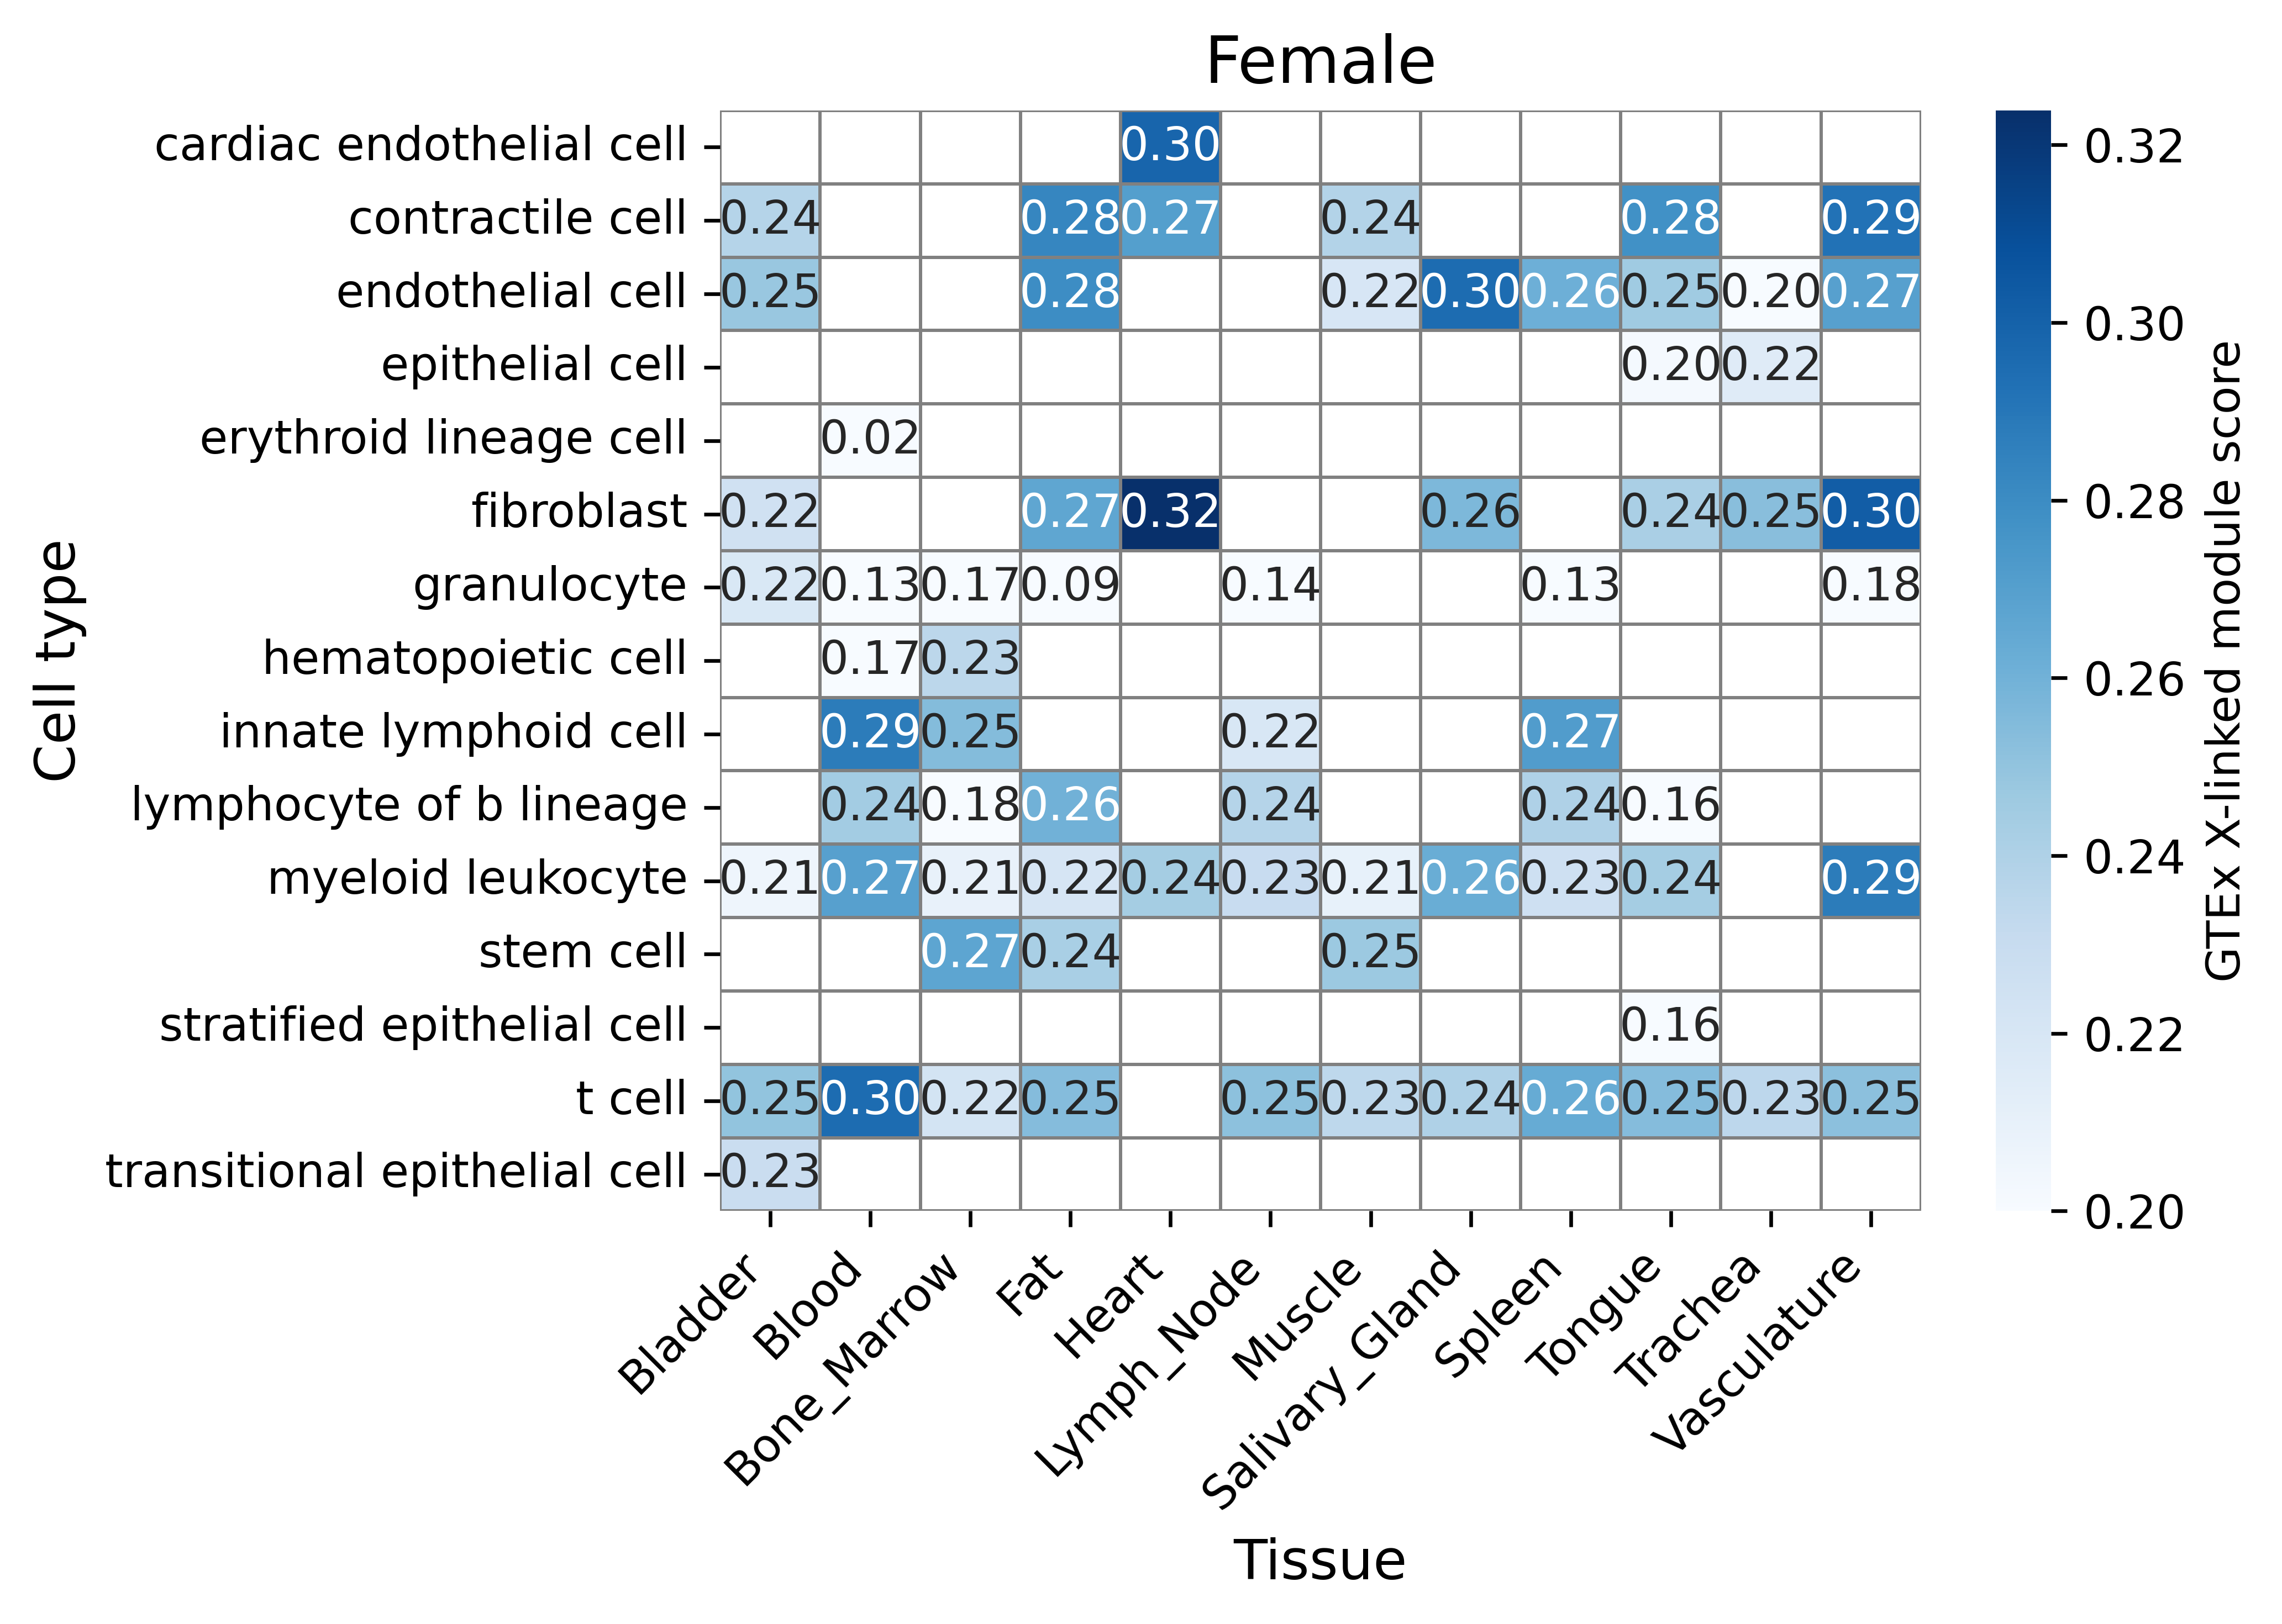

In [74]:
# Filter to only one sex
mpl.rcParams['pdf.fonttype'] = 42   # TrueType fonts
mpl.rcParams['ps.fonttype'] = 42

df_female = df[df['sex'] == 'female'].copy()

# Pivot table: rows = cell type, columns = tissue
heatmap_data = df_female.pivot_table(
    index='cell_type',
    columns='tissue',
    values='mean_GTEx_Xcorr_score',
    aggfunc='mean'
)

# Optional: sort rows and columns
heatmap_data = heatmap_data.sort_index(axis=0).sort_index(axis=1)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6.9,5),dpi=600)
sns.heatmap(
    heatmap_data,
    cmap='Blues',            # Diverging colormap
    annot=True,             # Display numerical values
    fmt=".2f",              # Two decimal places
    linewidths=0.5,
    vmin=0.2,
    linecolor='gray',
    cbar_kws={"label": "GTEx X-linked module score"}
)

plt.title("Female", fontsize=14)
plt.xlabel("Tissue", fontsize=12)
plt.ylabel("Cell type", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('R11-4.pdf',dpi=800,format='pdf')

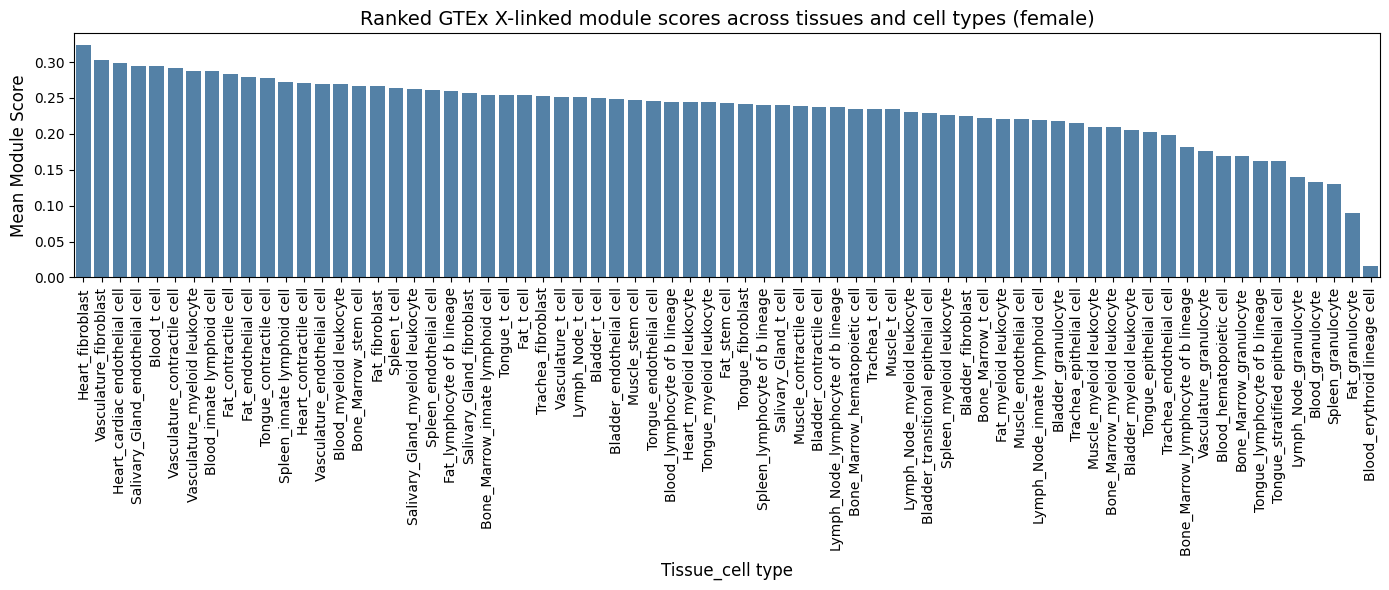

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42   # TrueType fonts
mpl.rcParams['ps.fonttype'] = 42

# Flatten and clean the data
barplot_data = heatmap_data.reset_index().melt(id_vars='cell_type', var_name='tissue', value_name='mean_GTEx_Xcorr_score')
barplot_data = barplot_data.dropna()

# Create combined label
barplot_data['celltype_tissue'] = barplot_data['tissue']+'_'+barplot_data['cell_type']

# Sort by score (descending)
barplot_data = barplot_data.sort_values(by='mean_GTEx_Xcorr_score', ascending=False)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(
    data=barplot_data,
    x='celltype_tissue',
    y='mean_GTEx_Xcorr_score',
    color='steelblue'
)

plt.xticks(rotation=90)
plt.title("Ranked GTEx X-linked module scores across tissues and cell types (female)", fontsize=14)
plt.xlabel("Tissue_cell type", fontsize=12)
plt.ylabel("Mean Module Score", fontsize=12)
plt.tight_layout()
plt.show()
pd.DataFrame(barplot_data.celltype_tissue.values).to_csv('female_tissue_ct_rank.csv')

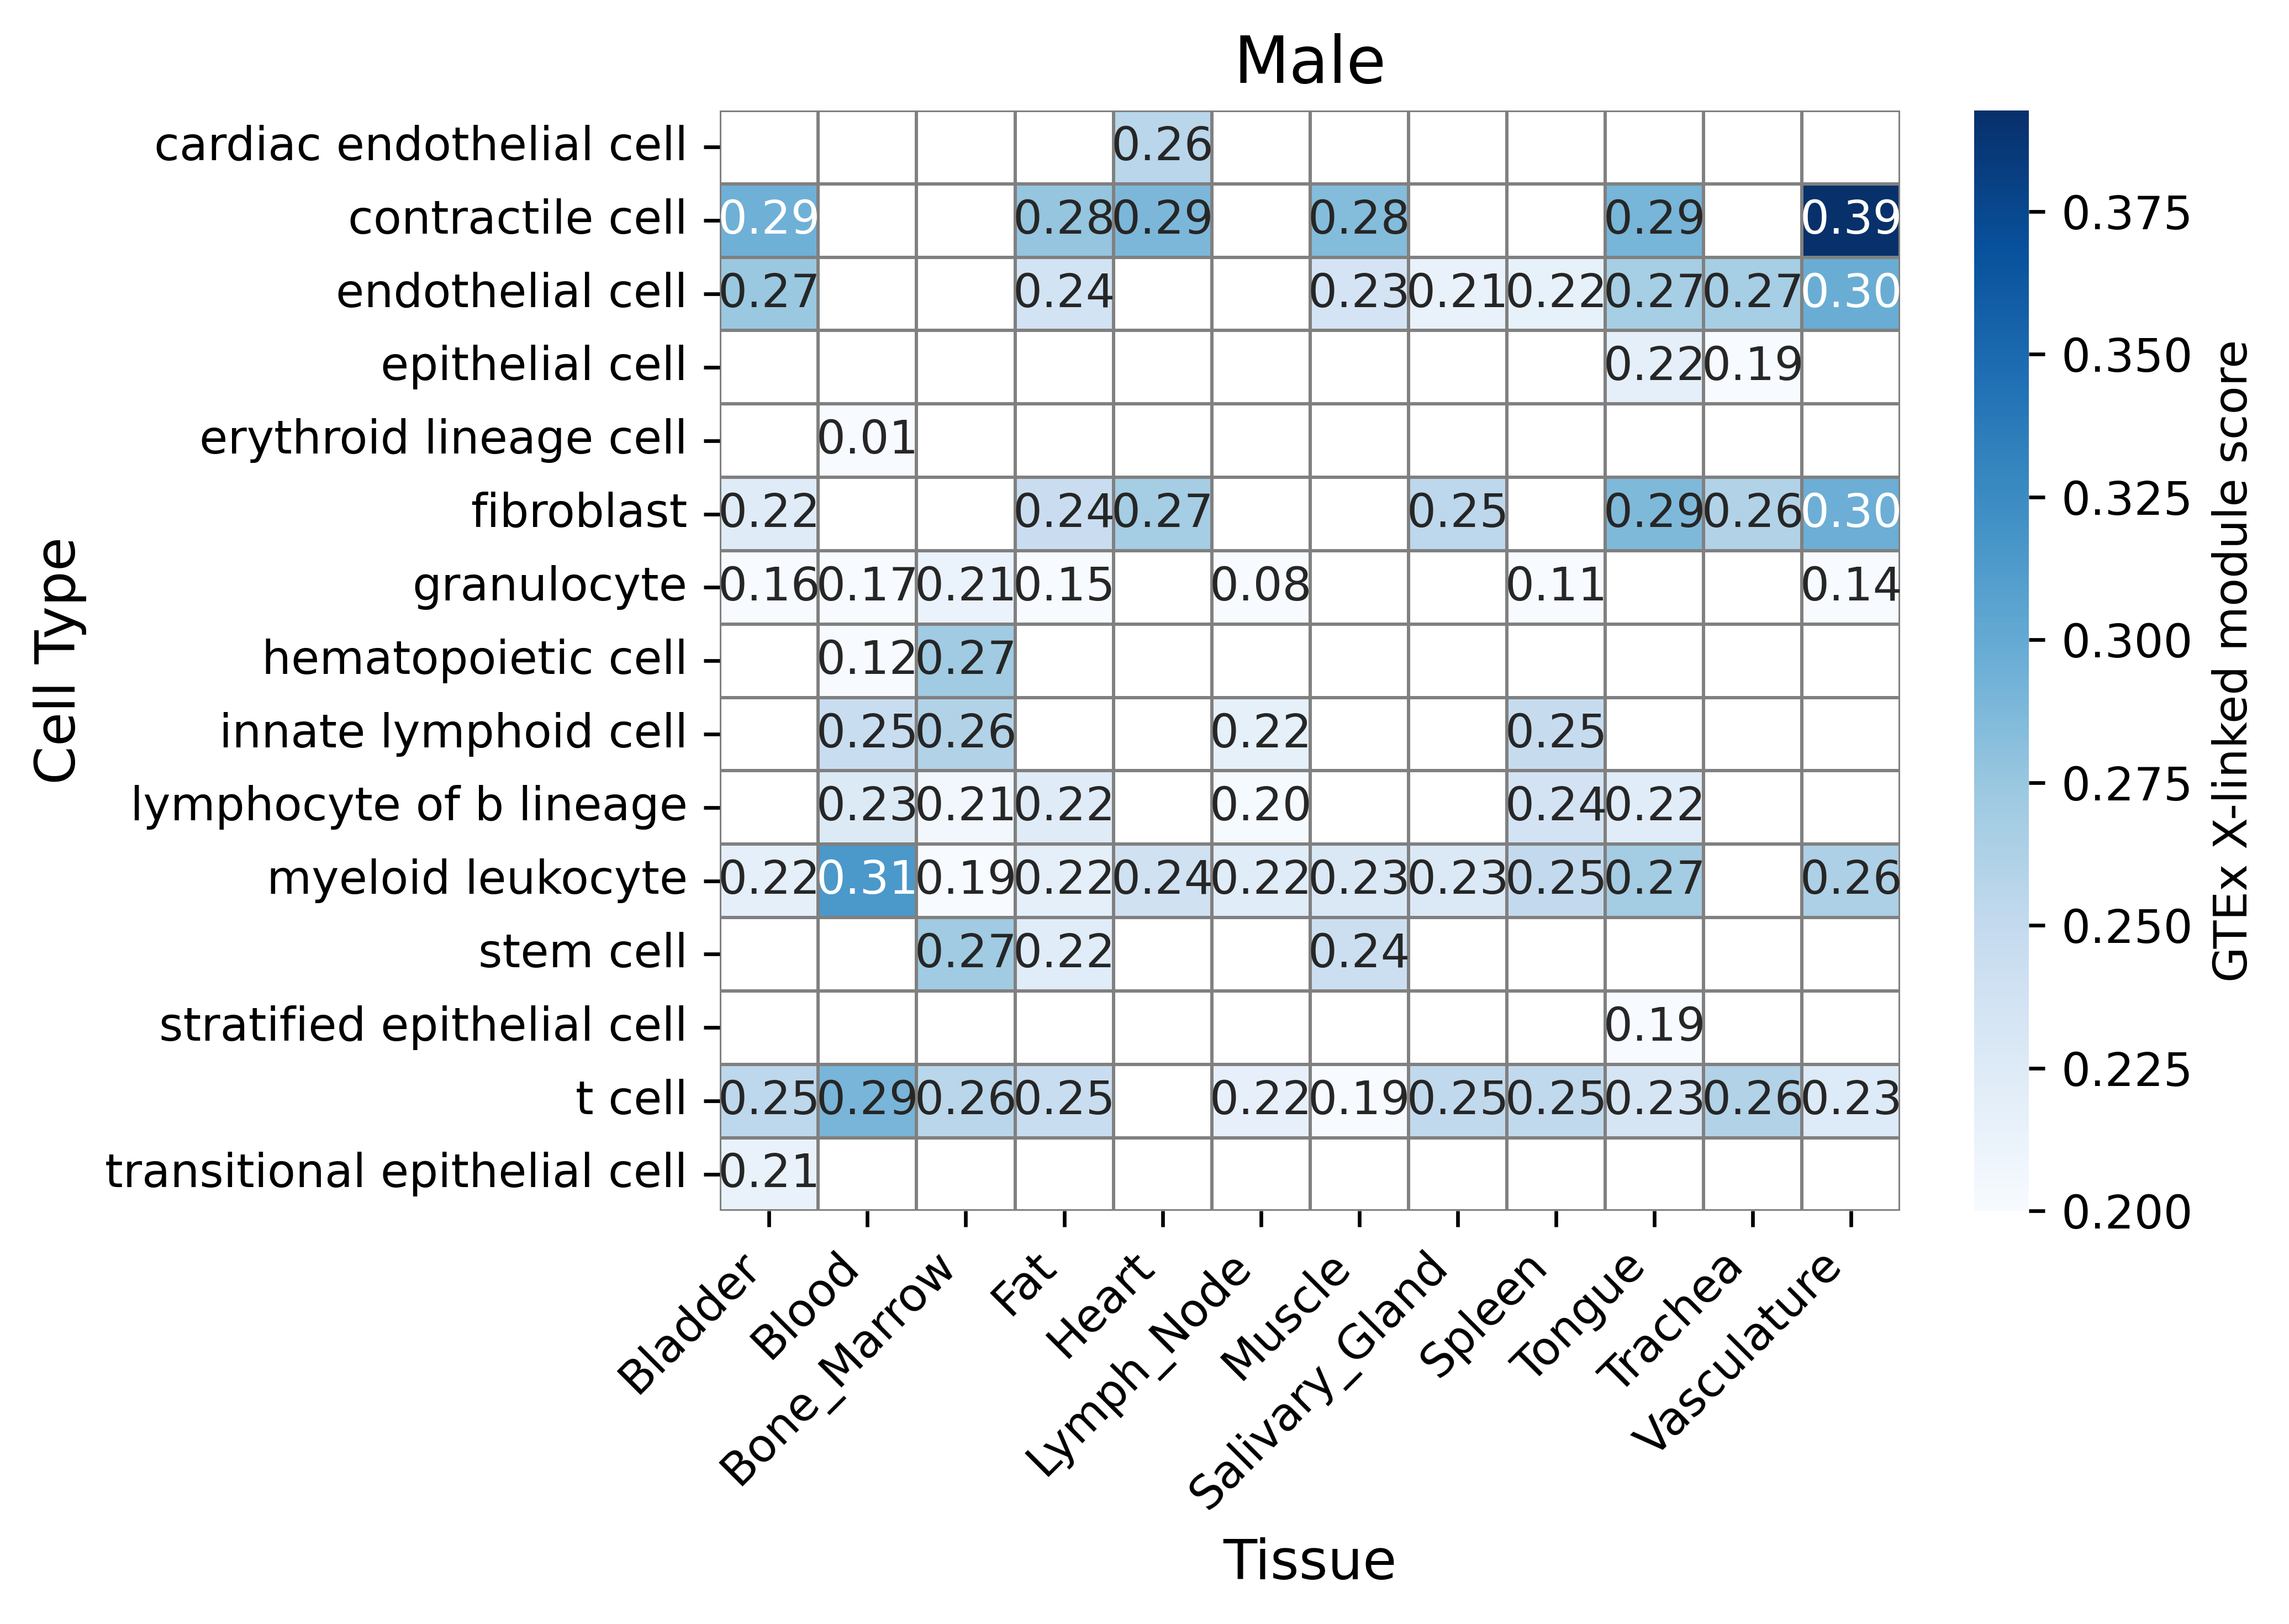

In [73]:
# Filter to only one sex
df_male = df[df['sex'] == 'male'].copy()
mpl.rcParams['pdf.fonttype'] = 42   # TrueType fonts
mpl.rcParams['ps.fonttype'] = 42

# Pivot table: rows = cell type, columns = tissue
heatmap_data = df_male.pivot_table(
    index='cell_type',
    columns='tissue',
    values='mean_GTEx_Xcorr_score',
    aggfunc='mean'
)

# Optional: sort rows and columns
heatmap_data = heatmap_data.sort_index(axis=0).sort_index(axis=1)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6.9,5),dpi=600)
sns.heatmap(
    heatmap_data,
    cmap='Blues',            # Diverging colormap
    annot=True,             # Display numerical values
    fmt=".2f",              # Two decimal places
    linewidths=0.5,
    vmin=0.2,
    linecolor='gray',
    cbar_kws={"label": "GTEx X-linked module score"}
)

plt.title("Male", fontsize=14)
plt.xlabel("Tissue", fontsize=12)
plt.ylabel("Cell Type", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig('R11-5.pdf',dpi=800,format='pdf')

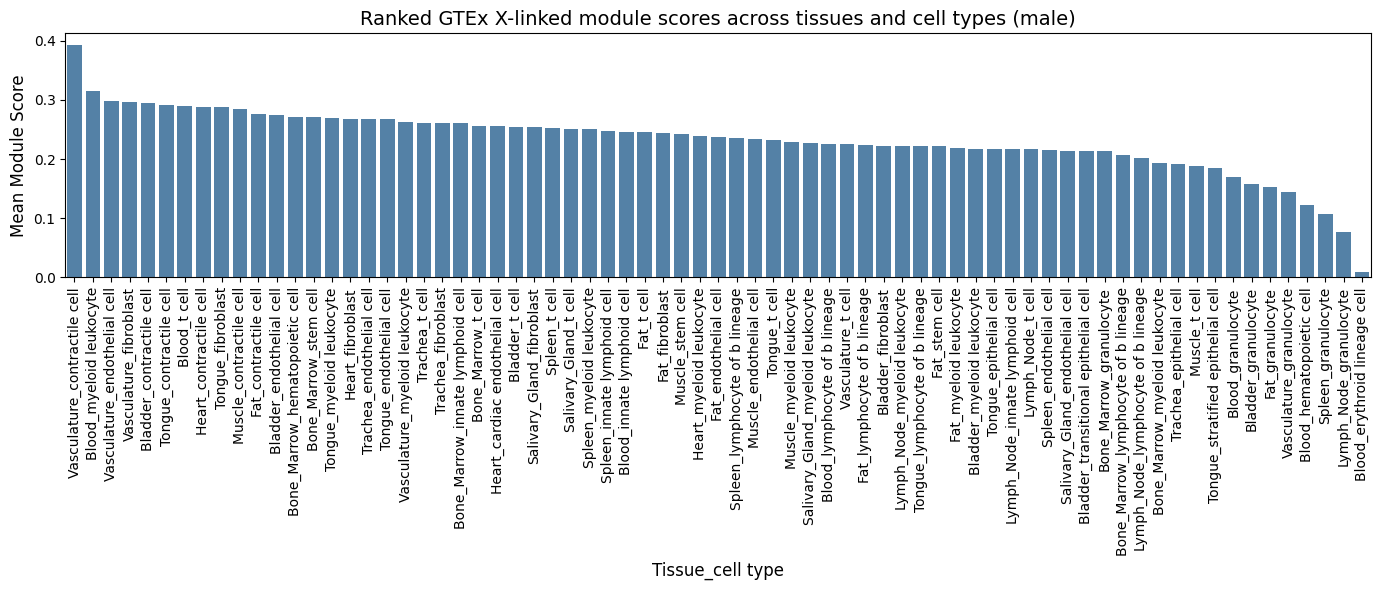

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten and clean the data
barplot_data = heatmap_data.reset_index().melt(id_vars='cell_type', var_name='tissue', value_name='mean_GTEx_Xcorr_score')
barplot_data = barplot_data.dropna()

# Create combined label
barplot_data['celltype_tissue'] = barplot_data['tissue']+'_'+barplot_data['cell_type']

# Sort by score (descending)
barplot_data = barplot_data.sort_values(by='mean_GTEx_Xcorr_score', ascending=False)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(
    data=barplot_data,
    x='celltype_tissue',
    y='mean_GTEx_Xcorr_score',
    color='steelblue'
)

plt.xticks(rotation=90)
plt.title("Ranked GTEx X-linked module scores across tissues and cell types (male)", fontsize=14)
plt.xlabel("Tissue_cell type", fontsize=12)
plt.ylabel("Mean Module Score", fontsize=12)
plt.tight_layout()
plt.show()
pd.DataFrame(barplot_data.celltype_tissue.values).to_csv('male_tissue_ct_rank.csv')

In [165]:
## compare the rank:
GTEx_male = pd.read_csv('male_tissue_ct_rank.csv',index_col=0)
GTEx_male.columns=['rank_GTEx']

GTEx_female = pd.read_csv('female_tissue_ct_rank.csv',index_col=0)
GTEx_female.columns=['rank_GTEx']

TS_female = pd.read_csv('TS_female_tissue_ct_rank.csv',index_col=0)
TS_female.columns=['rank_TS']

TS_male = pd.read_csv('TS_male_tissue_ct_rank.csv',index_col=0)
TS_male.columns=['rank_TS']

# Reset index to ensure consistent structure
GTEx_male = GTEx_male.reset_index().rename(columns={'index': 'celltype_tissue'})
GTEx_female = GTEx_female.reset_index().rename(columns={'index': 'celltype_tissue'})
TS_male = TS_male.reset_index().rename(columns={'index': 'celltype_tissue'})
TS_female = TS_female.reset_index().rename(columns={'index': 'celltype_tissue'})


In [166]:
df_compare = pd.merge(GTEx_female, TS_female, on='celltype_tissue', suffixes=('_GTEx', '_TS'))

from scipy.stats import spearmanr, kendalltau

# Spearman
rho, pval = spearmanr(df_compare['rank_GTEx'], df_compare['rank_TS'])
print(f"Spearman correlation: {rho:.3f} (p={pval:.2e})")

# Kendall tau
tau, pval_k = kendalltau(df_compare['rank_GTEx'], df_compare['rank_TS'])
print(f"Kendall's tau: {tau:.3f} (p={pval_k:.2e})")


df_compare = pd.merge(GTEx_male, TS_male, on='celltype_tissue', suffixes=('_GTEx', '_TS'))

from scipy.stats import spearmanr, kendalltau

# Spearman
rho, pval = spearmanr(df_compare['rank_GTEx'], df_compare['rank_TS'])
print(f"Spearman correlation: {rho:.3f} (p={pval:.2e})")

# Kendall tau
tau, pval_k = kendalltau(df_compare['rank_GTEx'], df_compare['rank_TS'])
print(f"Kendall's tau: {tau:.3f} (p={pval_k:.2e})")


Spearman correlation: 0.319 (p=1.55e-02)
Kendall's tau: 0.214 (p=1.86e-02)
Spearman correlation: 0.111 (p=4.12e-01)
Kendall's tau: 0.076 (p=4.01e-01)


In [171]:
TS_female

celltype_tissue                               rank_TS
0                 0              Bladder_contractile cell
1                 1        Bone_Marrow_hematopoietic cell
2                 2                    Trachea_fibroblast
3                 3               Tongue_contractile cell
4                 4                         Fat_stem cell
5                 5               Muscle_contractile cell
6                 6              Muscle_myeloid leukocyte
7                 7                 Bone_Marrow_stem cell
8                 8                   Bladder_granulocyte
9                 9                  Fat_contractile cell
10               10              Tongue_myeloid leukocyte
11               11      Salivary_Gland_myeloid leukocyte
12               12             Salivary_Gland_fibroblast
13               13               Tongue_endothelial cell
14               14           Fat_lymphocyte of b lineage
15               15  Bladder_transitional epithelial cell
16               16     Tongue_stratified epithelial cell
17               17                         Tongue_t cell
18               18              Spleen_myeloid leukocyte
19               19                Vasculature_fibroblast
20               20                    Bladder_fibroblast
21               21                    Vasculature_t cell
22               22               Bone_Marrow_granulocyte
23               23                       Fat_granulocyte
24               24        Heart_cardiac endothelial cell
25               25          Vasculature_contractile cell
26               26                    Spleen_granulocyte
27               27         Vasculature_myeloid leukocyte
28               28                        Bladder_t cell
29               29                 Fat_myeloid leukocyte
30               30               Trachea_epithelial cell
31               31                 Salivary_Gland_t cell
32               32                        Trachea_t cell
33               33               Muscle_endothelial cell
34               34          Vasculature_endothelial cell
35               35         Bone_Marrow_myeloid leukocyte
36               36                Tongue_epithelial cell
37               37                      Muscle_stem cell
38               38             Bladder_myeloid leukocyte
39               39                        Fat_fibroblast
40               40      Bone_Marrow_innate lymphoid cell
41               41                     Blood_granulocyte
42               42                    Bone_Marrow_t cell
43               43            Blood_innate lymphoid cell
44               44    Lymph_Node_lymphocyte of b lineage
45               45       Lymph_Node_innate lymphoid cell
46               46         Blood_lymphocyte of b lineage
47               47                            Fat_t cell
48               48                         Spleen_t cell
49               49                     Lymph_Node_t cell
50               50           Spleen_innate lymphoid cell
51               51               Blood_myeloid leukocyte
52               52                          Blood_t cell
53               53   Bone_Marrow_lymphocyte of b lineage
54               54          Blood_erythroid lineage cell
55               55        Spleen_lymphocyte of b lineage
56               56          Lymph_Node_myeloid leukocyte

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

k = 57

# Female
top_gtex_f = set(GTEx_female.sort_values('rank_GTEx').head(k)['celltype_tissue'])
top_ts_f = set(TS_female.sort_values('rank_TS').head(k)['celltype_tissue'])
overlap_f = top_gtex_f & top_ts_f
jaccard_f = len(overlap_f) / len(top_gtex_f | top_ts_f)

# Male
top_gtex_m = set(GTEx_male.sort_values('rank_GTEx').head(k)['celltype_tissue'])
top_ts_m = set(TS_male.sort_values('rank_TS').head(k)['celltype_tissue'])
overlap_m = top_gtex_m & top_ts_m
jaccard_m = len(overlap_m) / len(top_gtex_m | top_ts_m)

# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'sex': ['Female', 'Male'],
    'Jaccard Similarity': [jaccard_f, jaccard_m],
    'Top-k Overlap Count': [len(overlap_f), len(overlap_m)]
})


/tmp/ipykernel_3383168/2040015734.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



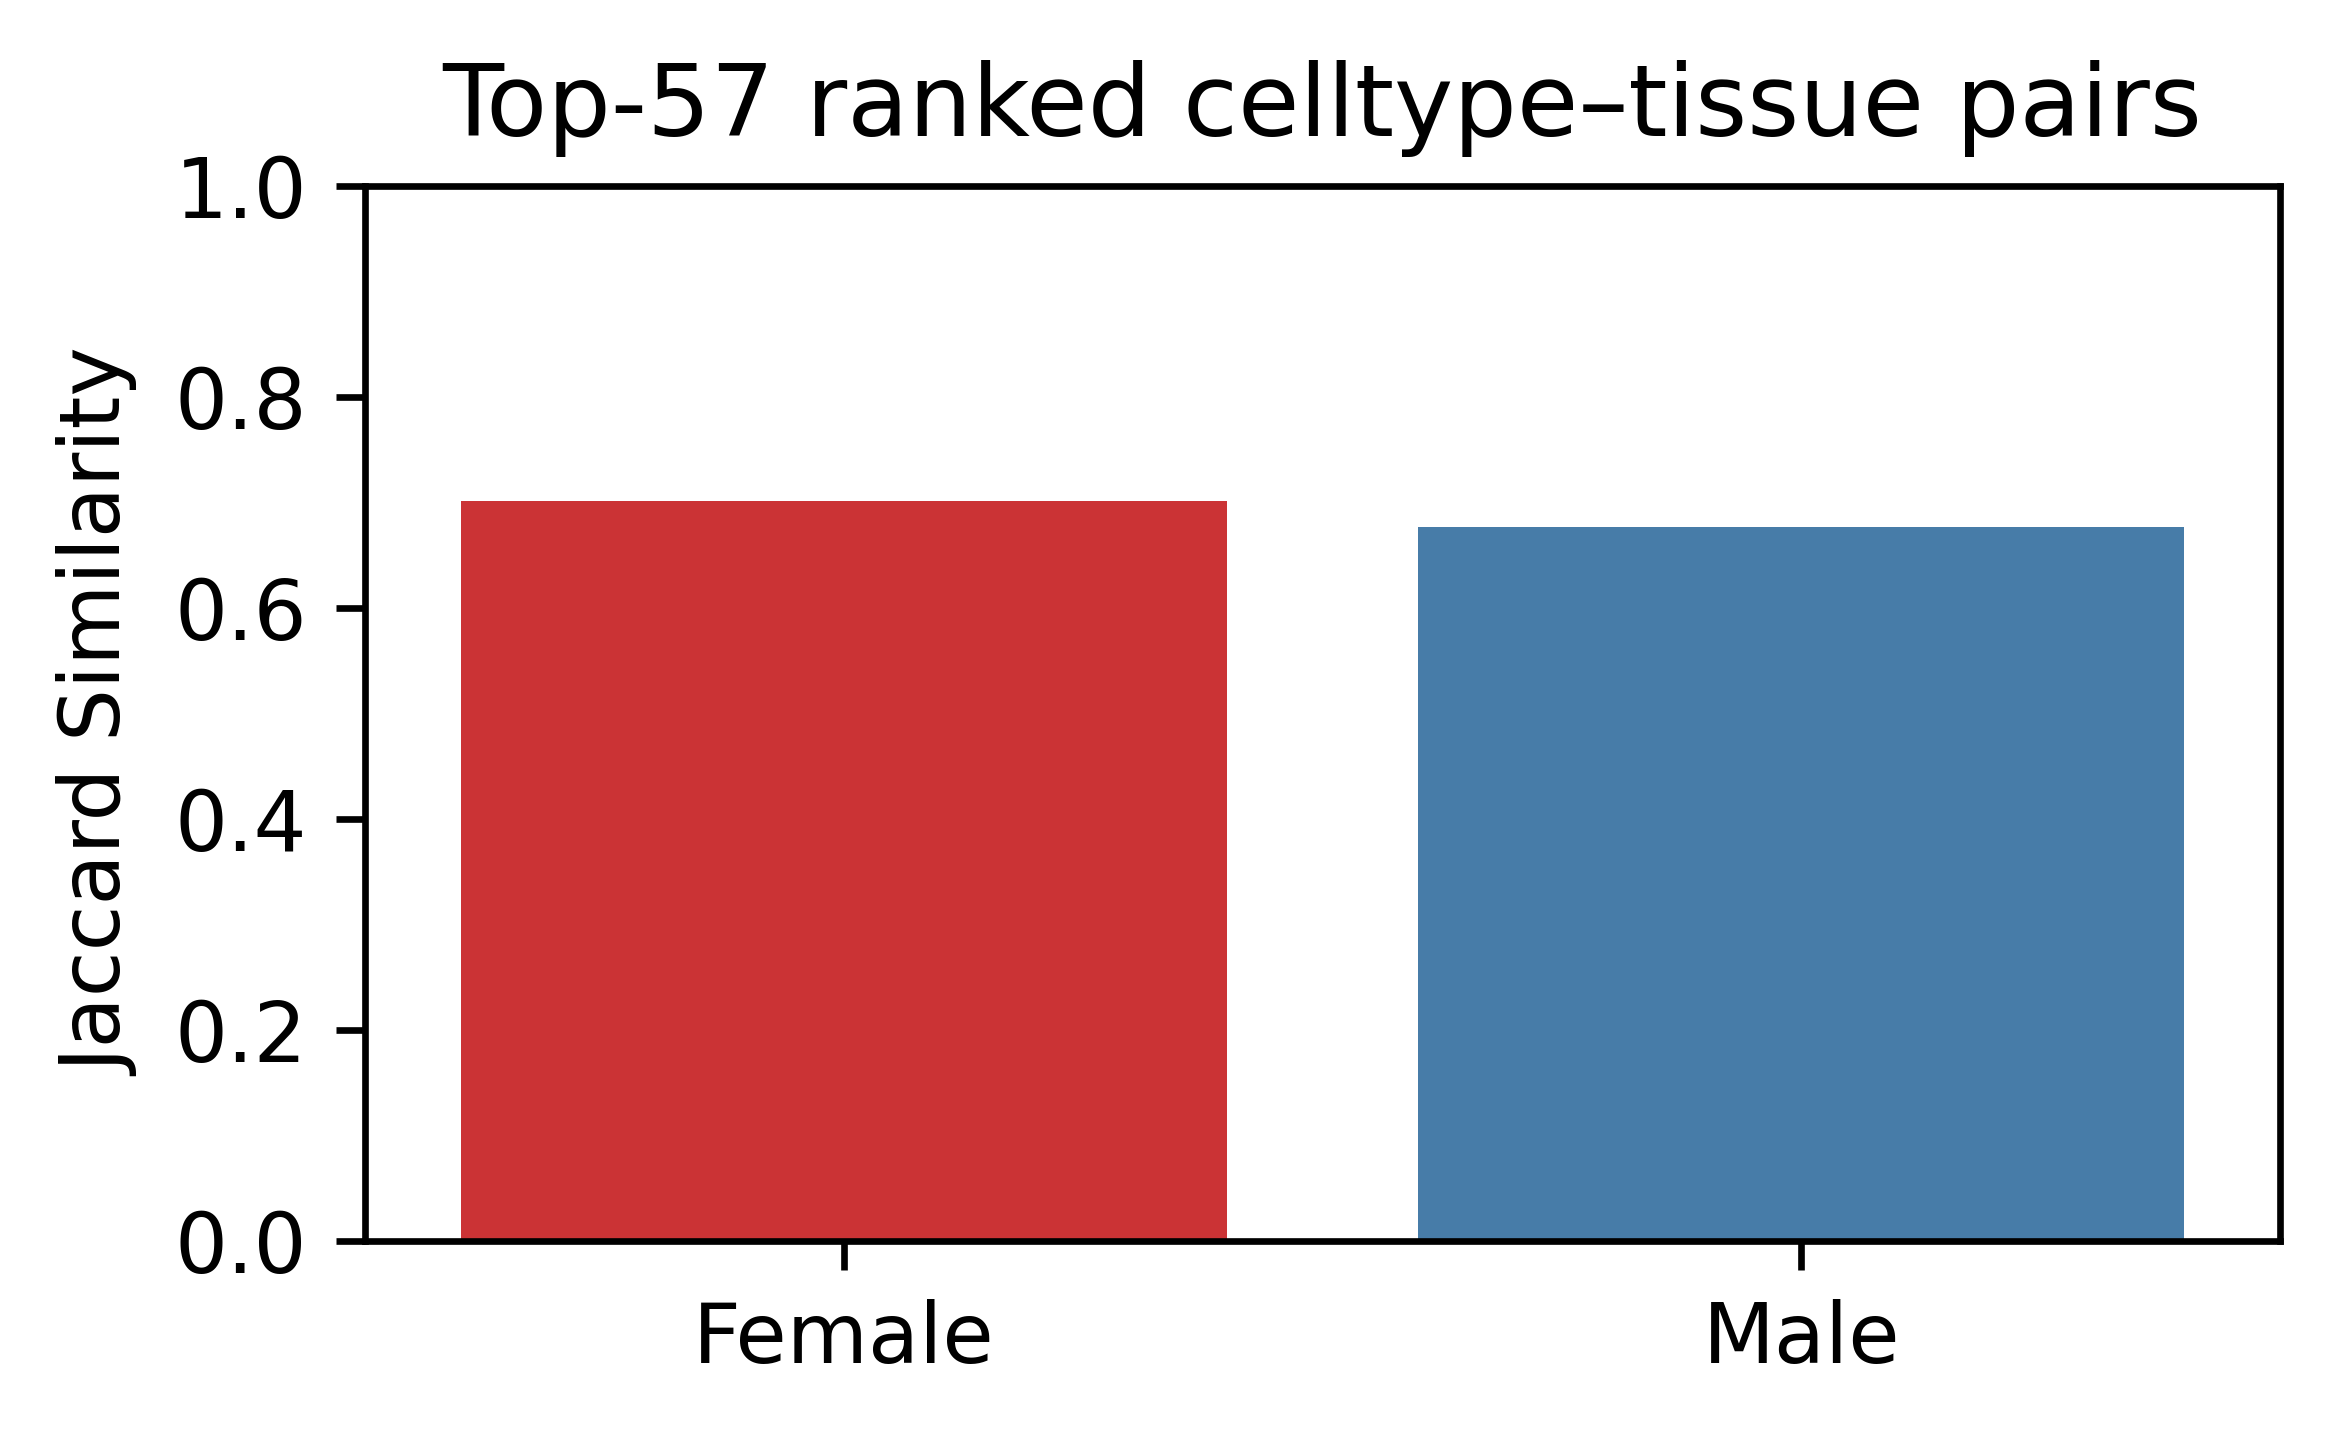

In [176]:
plt.figure(figsize=(4,2.5),dpi=600)
sns.barplot(data=df_plot, x='sex', y='Jaccard Similarity', palette='Set1')
plt.ylim(0, 1)
plt.title(f'Top-{k} ranked celltype–tissue pairs')
plt.ylabel('Jaccard Similarity')
plt.xlabel('')
plt.tight_layout()
plt.savefig('R11-6.pdf',dpi=800,format='pdf')


In [174]:
df_plot

sex  Jaccard Similarity  Top-k Overlap Count
0  Female            0.701493                   47
1    Male            0.676471                   46